**This notebook is not for showcasing the final work, just an interactive python environment to tune model parameters.**

# Functions

In [127]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, Ridge
from pickle import load, dump
from os.path import exists

# Change THREAD to change model and prediction name
THREAD = '_1~10'

TRAIN_TEXT = '../../data/text_train.csv'
TEST_TEXT = '../../data/text_test.csv'
VALI_TEXT = '../../data/text_validate.csv'
MINI_TEXT = '../../data/text_mini.csv'
PREDICTION_CSV = '../../static/prediction.csv'
VECTOR = '../../static/tf_vector.pickle'
MATRIX = '../../static/tf_matrix.pickle'
PREDICTION = './config/prediction{}.csv'.format(THREAD)
MODEL = './config/model{}.pickle'.format(THREAD)

STOP = set(stopwords.words("english"))
STEMMER = SnowballStemmer("english")
LOAD_NEW = False

# Tunable parameters
MAX_DF = 1.0  # We already have stop words, probably don't need this
MIN_DF = 2  # Discard words which not show up twice in all document
MAX_FEATURE = None  # IF no memory, tune this down
MIN_N = 1
MAX_N = 1  # Uni-gram

# Used to specify the norm used in the penalization. The ‘newton-cg’,
# ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.
PENALTY = 'l2'
DUAL = False  # Feature > sample then true

Preparation functions

In [2]:
def tokenize(text):
    """ Helper function for TFIDF vector from sklearn. We use nltk's tokenize
        function here. Also use snowball as stemmer (the middle agressive
        one).
    """
    # Filter out stop words, tokenize the text
    useful_token = [w.lower() for w in word_tokenize(text) if w not in STOP]

    # Stemming the tokens
    stemmed_token = [STEMMER.stem(t) for t in useful_token]

    return stemmed_token

In [176]:
def vectorize_text(train_txt, vali_txt, test_txt, vector, matrix, re_load,
                   min_df=1, max_df=1.0, max_feature=None, min_n=1, max_n=1):
    """ Feature engineering from the raw text input. """
    # If there is saved model, then just use it
    if exists(vector) and exists(matrix) and not re_load:
        # Get train length
        table_train = pd.read_csv(train_txt)

        # Load stored data
        all_mat = load(open(matrix, 'rb'))
        x_train = all_mat[:table_train.shape[0]]
        tf = load(open(vector, 'rb'))

    else:
        # Read all files
        table_train = pd.read_csv(train_txt)
        table_test = pd.read_csv(vali_txt)
        table_vali = pd.read_csv(test_txt)

        text_train = table_train['clean'].tolist()
        text_test = table_test['clean'].tolist()
        text_vali = table_vali['clean'].tolist()

        # We want to have a overall vocabulary bank as `np.py`, so we combine
        # all the text first
        all_text = text_train + text_test + text_vali

        # Record the length so we can recover the training set
        train_length = len(text_train)

        # Initialize TFID arguments
        # Only work for English, discard all Chinese
        tf = TfidfVectorizer(min_df=min_df, max_features=max_feature,
                             strip_accents='ascii', analyzer='word',
                             tokenizer=tokenize, ngram_range=(min_n, max_n))

        # Vectorize all, and transform (more efficient than fit + transform)
        all_mat = tf.fit_transform(all_text)

        # Recover the training data
        x_train = all_mat[:train_length]

        # Store the fitted matrix and tf_vectorizor
        dump(all_mat, open(matrix, 'wb'))
        dump(tf, open(vector, 'wb'))

    print("Successfully load TF-IDF matrix, with shape {}.".format(
        x_train.shape))

    return tf, all_mat, x_train

In [4]:
def vectorize_text_count(train_txt, vali_txt, test_txt, vector, matrix, re_load,
                   min_df=1, max_df=1.0, max_feature=None, min_n=1, max_n=1):
    """ Feature engineering from the raw text input. """
    # If there is saved model, then just use it
    if exists(vector) and exists(matrix) and not re_load:
        # Get train length
        table_train = pd.read_csv(train_txt)

        # Load stored data
        all_mat = load(open(matrix, 'rb'))
        x_train = all_mat[:table_train.shape[0]]
        tf = load(open(vector, 'rb'))

    else:
        # Read all files
        table_train = pd.read_csv(train_txt)
        table_test = pd.read_csv(vali_txt)
        table_vali = pd.read_csv(test_txt)

        text_train = table_train['text'].tolist()
        text_test = table_test['text'].tolist()
        text_vali = table_vali['text'].tolist()

        # We want to have a overall vocabulary bank as `np.py`, so we combine
        # all the text first
        all_text = text_train + text_test + text_vali

        # Record the length so we can recover the training set
        train_length = len(text_train)

        # Initialize TFID arguments
        # Only work for English, discard all Chinese
        tf = CountVectorizer(min_df=min_df, max_features=max_feature,
                             strip_accents='ascii', analyzer='word',
                             tokenizer=tokenize, ngram_range=(min_n, max_n))

        # Vectorize all, and transform (more efficient than fit + transform)
        all_mat = tf.fit_transform(all_text)

        # Recover the training data
        x_train = all_mat[:train_length]

        # Store the fitted matrix and tf_vectorizor
        dump(all_mat, open(matrix, 'wb'))
        dump(tf, open(vector, 'wb'))

    print("Successfully load TF-IDF matrix, with shape {}.".format(
        x_train.shape))

    return tf, all_mat, x_train

In [5]:
def score(estimator, x_test, y_test):
    """ Use mean squared error as score for cv."""
    probs = estimator.predict_proba(x_test)
    result = np.zeros(x_test.shape[0])
    for i in range(probs.shape[0]):
        result[i] = dis_to_conti(probs[i])
    y_int = np.array(list(map(int, y_test)))
    # We want to minimize the error
    score = (-1) * np.sqrt(np.mean(np.square(result - y_int)))
    return score


def dis_to_conti(probability):
    """ The kaggle grading is unfair, so I want to force bayesian classifier
        gives a continuous result.
    """
    return sum(probability * np.arange(1, 6))

def score_mlr(estimator, x_test, y_test):
    """ Use mean squared error as score for cv."""
    result = estimator.predict(x_test)
    y_int = np.array(list(map(int, y_test)))

    # We want to minimize the error
    score = (-1) * np.sqrt(np.mean(np.square(result - y_int)))
    return score

In [6]:
def train_lr(x_train, y_train, model_name):
    """ Train a logistic regression model."""
    # Use cross validation to search features
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    # param_grid = {'C': [1, 5]}
    best_model = GridSearchCV(LogisticRegression(penalty=PENALTY, dual=DUAL),
                              param_grid, scoring=score, cv=10)

    best_model.fit(x_train, y_train)
    print(best_model.best_estimator_)

    # Save the model
    dump(best_model, open(model_name, 'wb'))

    return best_model

In [7]:
def predict(estimator, all_matrix, train_length, output_csv):
    """ Predict the test and validation text, and write to csv."""
    # Read the text
    # `all_matrix` has already contained all the test and vali text
    x_predict = all_matrix[train_length:]
    print("Successfully load predicting text, with shape {}.".format(
        x_predict.shape))

    prediction = estimator.predict_proba(x_predict)

    # Convert probability to continuous scores
    result = np.zeros(x_predict.shape[0])
    for i in range(prediction.shape[0]):
        result[i] = dis_to_conti(prediction[i])

    # Combine ID and write to a file
    with open(output_csv, 'w') as output:
        output.write('"Id","Prediction"\n')
        for i in range(len(result)):
            # The id number is 1-indexed
            output.write("{},{}\n".format(i + 1, result[i]))

def predict_mlr(estimator, all_matrix, train_length, output_csv):
    """ Predict the test and validation text, and write to csv. The estimator
        should be a prediction estimator, instead of a classifier.
    """
    # Read the text
    # `all_matrix` has already contained all the test and vali text
    x_predict = all_matrix[train_length:]
    print("Successfully load predicting text, with shape {}.".format(
        x_predict.shape))

    prediction = estimator.predict(x_predict)

    # Combine ID and write to a file
    with open(output_csv, 'w') as output:
        output.write('"Id","Prediction"\n')
        for i in range(len(prediction)):
            output.write("{},{}\n".format(i, prediction[i]))

In [177]:
print("Start vectorizing...")
tf, all_mat, x_train = vectorize_text(TRAIN_TEXT, TEST_TEXT, VALI_TEXT,
                                      VECTOR, MATRIX, False,
                                      min_df=MIN_DF, max_df=MAX_DF,
                                      max_feature=MAX_FEATURE,
                                      min_n=MIN_N, max_n=MAX_N)
# predict(test_model, all_mat, x_train.shape[0], './config/prediction_lasso_1-6.csv')
# Make label for train_v
table_train = pd.read_csv(TRAIN_TEXT)

# Use string to represent the categories
y_train = list(map(str, table_train['stars']))

Start vectorizing...
Successfully load TF-IDF matrix, with shape (36692, 21888).


# Tuning for Unigram

In [11]:
# Make label for train_v
table_train = pd.read_csv(TRAIN_TEXT)
# Use string to represent the categories
y_train = list(map(str, table_train['stars']))

# print("Start training...")
# lr = train_lr(x_train, y_train, MODEL)

# predict(lr.best_estimator_, all_mat, x_train.shape[0], PREDICTION)

Start vectorizing...
Successfully load TF-IDF matrix, with shape (36692, 23617).


In [18]:
cv_result = pd.DataFrame.from_dict(lr.cv_results_, orient='index')
cv_result.columns = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_result

,0.001,0.01,0.1,1.0,10.0,100.0,1000.0
split4_train_score,-1.63391,-1.37801,-0.846607,-0.496936,-0.28908,-0.135901,-0.0645506
split2_test_score,-1.63715,-1.39592,-0.904112,-0.625058,-0.590711,-0.7099,-0.927654
mean_fit_time,0.709696,1.02414,1.61381,2.84692,5.74794,13.1925,32.3762
split3_test_score,-1.63433,-1.37618,-0.847281,-0.558943,-0.530479,-0.663934,-0.880629
split9_train_score,-1.63443,-1.37924,-0.844654,-0.495111,-0.288394,-0.135352,-0.0632319
std_test_score,0.00164988,0.00753849,0.016486,0.0210609,0.0247995,0.0324021,0.0385761
rank_test_score,7,6,4,2,1,3,5
split8_train_score,-1.63496,-1.38159,-0.849273,-0.499018,-0.290315,-0.135404,-0.0627491
mean_test_score,-1.63528,-1.38569,-0.875304,-0.593716,-0.564088,-0.69626,-0.913187
split9_test_score,-1.63488,-1.38901,-0.89233,-0.615577,-0.577727,-0.678939,-0.850457


We got 0.56 mean squared error on the training data. Let's see how it works for the test and vali data.

In [26]:
predict(lr.best_estimator_, all_mat, x_train.shape[0], "prediction.csv")

Successfully load predicting text, with shape (24461, 23617).
Wrote to the output prediction.csv


Maybe we can get better result by keep tuning the regularization strength.

In [20]:
# Use cross validation to search parameter (regularization strength)
param_grid = {'C': range(3,6)}
better_model = GridSearchCV(LogisticRegression(penalty=PENALTY, dual=DUAL),
                          param_grid, scoring=score, cv=5, n_jobs=4)

better_model.fit(x_train, y_train)
dump(better_model, open(MODEL, 'wb'))

KeyboardInterrupt: 

In [44]:
cv_result_better = pd.DataFrame.from_dict(better_model.cv_results_, orient='index')
cv_result_better.columns = range(3,6)
cv_result_better

,3,4,5
split4_test_score,-0.74867,-0.746095,-0.745346
split3_train_score,-0.624197,-0.602078,-0.584653
mean_test_score,-0.74921,-0.747209,-0.74692
std_train_score,0.00131852,0.00133528,0.00134358
split1_train_score,-0.624658,-0.602595,-0.585216
split3_test_score,-0.749274,-0.747912,-0.748137
std_fit_time,0.382927,0.31633,0.978515
std_score_time,0.00864954,0.0149153,0.0140285
rank_test_score,3,2,1
param_C,3,4,5


In [49]:
test = LogisticRegression(C=2, penalty='l1')
test.fit(x_train, y_train)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [54]:
coef = test.coef_[4]
index = np.argpartition(coef, -10)[-10:]
#index = [7067, 868, 3652, 19508, 12097, 12503, 7884, 2618, 13874, 23389]
for i in index:
    for k, v in tf.vocabulary_.items():
        if i == v:
            print(k)
print(coef[index[12]])
coef[1:10]
#tf.vocabulary_

phenomen
exceed
mmmmmmm
hue
superb
best
amaz
banzo
favorit
sophia


IndexError: index 12 is out of bounds for axis 0 with size 10

Therefore, for now, we just keep using c = 4.

In [18]:
predict(better_model.best_estimator_, all_mat, x_train.shape[0], PREDICTION)

Successfully load predicting text, with shape (24461, 23617).


See how TF-IDF matrix look like.

In [26]:
print(all_mat[0][:10])

  (0, 19615)	0.13538616739
  (0, 0)	0.177035528504
  (0, 14368)	0.086454396434
  (0, 23394)	0.0903257044619
  (0, 18)	0.0914622594844
  (0, 8022)	0.173126772941
  (0, 6995)	0.154364864126
  (0, 173)	0.230221927247
  (0, 2994)	0.0588120425056
  (0, 6518)	0.13580411238
  (0, 3620)	0.125624228969
  (0, 8023)	0.13624184676
  (0, 3512)	0.0751911573647
  (0, 6070)	0.243957007807
  (0, 4878)	0.244542232848
  (0, 11102)	0.110095344717
  (0, 9004)	0.0769081056065
  (0, 17618)	0.222637529068
  (0, 16639)	0.175006803316
  (0, 344)	0.0734072607975
  (0, 19039)	0.162969581364
  (0, 19893)	0.0980655529045
  (0, 16998)	0.0884625970817
  (0, 15264)	0.119170684178
  (0, 8657)	0.18721852126
  :	:
  (0, 9816)	0.10271633557
  (0, 18111)	0.0789800307954
  (0, 12413)	0.10062393388
  (0, 15900)	0.0803202194759
  (0, 7380)	0.113373984273
  (0, 18142)	0.119594933902
  (0, 3065)	0.117136202154
  (0, 16485)	0.089357874059
  (0, 17866)	0.0969360665738
  (0, 13366)	0.124077938702
  (0, 13977)	0.122649925816
  (0, 

Try 2-gram feature, with regularizaiton term = 4.

In [32]:
tf, all_mat, x_train = vectorize_text(TRAIN_TEXT, VALI_TEXT, TEST_TEXT, 
                                      vector='../../static/tf_vector_2_gram.pickle', 
                                      matrix='../../static/tf_matrix_2_gram.pickle', re_load=False,
                                      min_df=1, max_df=1.0, max_feature=None, min_n=2, max_n=2)

# Make label for train_v
table_train = pd.read_csv(TRAIN_TEXT)

# Use string to represent the categories
y_train = list(map(str, table_train['stars']))

Successfully load TF-IDF matrix, with shape (36692, 1046524).


In [35]:
# Use cross validation to search parameter (regularization strength)
param_grid = {'C': [4]}
better_model = GridSearchCV(LogisticRegression(penalty=PENALTY, dual=True),
                          param_grid, scoring=score, cv=10)

better_model.fit(x_train, y_train)
dump(better_model, open('./config/model{}.pickle'.format('_2_gram_4'), 'wb'))

In [36]:
cv_result_better = pd.DataFrame.from_dict(better_model.cv_results_, orient='index')
cv_result_better

,0
rank_test_score,1
split3_test_score,-0.669253
std_train_score,0.000896907
param_C,4
std_test_score,0.0184079
mean_fit_time,3.55656
params,{'C': 4}
split9_test_score,-0.722854
split2_train_score,-0.24184
split4_test_score,-0.689041


Well, looks not that good, lets try to tune the parameter again.

In [37]:
# Use cross validation to search parameter (regularization strength)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
better_model = GridSearchCV(LogisticRegression(penalty=PENALTY, dual=True),
                          param_grid, scoring=score, cv=10)

better_model.fit(x_train, y_train)
dump(better_model, open('./config/model{}.pickle'.format('_2_gram_init'), 'wb'))

In [38]:
cv_result_better = pd.DataFrame.from_dict(better_model.cv_results_, orient='index')
cv_result_better

,0,1,2,3,4,5,6
rank_test_score,7,6,5,4,2,1,3
split3_test_score,-1.6703,-1.60476,-1.39568,-0.877016,-0.601214,-0.57516,-0.618154
std_train_score,8.25316e-05,0.000265205,0.00117758,0.00174121,0.00037835,1.88318e-05,5.25198e-07
param_C,0.001,0.01,0.1,1,10,100,1000
std_test_score,0.000545649,0.00138635,0.00623148,0.0151184,0.01978,0.0230089,0.0254126
mean_fit_time,2.31468,1.99449,1.96908,2.6542,6.10179,14.7557,15.3552
params,{'C': 0.001},{'C': 0.01},{'C': 0.1},{'C': 1},{'C': 10},{'C': 100},{'C': 1000}
split9_test_score,-1.66933,-1.60404,-1.40243,-0.916154,-0.659143,-0.637862,-0.684875
split2_train_score,-1.66937,-1.59941,-1.3559,-0.650916,-0.0907433,-0.00375308,-9.26273e-05
split4_test_score,-1.67027,-1.60561,-1.40474,-0.898603,-0.618091,-0.587724,-0.631872


It seems 2-gram itself is not good as unigram. 

Make a bad model to achieve about 0.9 error, to troll other students.

In [39]:
tf, all_mat, x_train = vectorize_text(TRAIN_TEXT, VALI_TEXT, TEST_TEXT, 
                                      vector=VECTOR, 
                                      matrix=MATRIX, re_load=False,
                                      min_df=1, max_df=1.0, max_feature=None, min_n=1, max_n=1)

# Make label for train_v
table_train = pd.read_csv(TRAIN_TEXT)

# Use string to represent the categories
y_train = list(map(str, table_train['stars']))

Successfully load TF-IDF matrix, with shape (36692, 23617).


In [71]:
bad_model = LogisticRegression(C=0.0685, class_weight=None, dual=True, fit_intercept=True,
              intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
              penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
              verbose=0, warm_start=False)
bad_model.fit(x_train, y_train)
predict(bad_model, all_mat, x_train.shape[0], './config/bad_prediction.csv')

Successfully load predicting text, with shape (24461, 23617).


In [66]:
predict(bad_model, all_mat, x_train.shape[0], './config/bad_prediction.csv')

Successfully load predicting text, with shape (24461, 23617).


Anyway, let's keep tuning the parameters for 2-gram.

In [74]:
tf, all_mat, x_train_2 = vectorize_text(TRAIN_TEXT, VALI_TEXT, TEST_TEXT, 
                                      vector='../../static/tf_vector_2_gram.pickle', 
                                      matrix='../../static/tf_matrix_2_gram.pickle', re_load=False,
                                      min_df=1, max_df=1.0, max_feature=None, min_n=2, max_n=2)

# Make label for train_v
table_train = pd.read_csv(TRAIN_TEXT)

# Use string to represent the categories
y_train_2 = list(map(str, table_train['stars']))

Successfully load TF-IDF matrix, with shape (36692, 1046524).


In [77]:
# Use cross validation to search parameter (regularization strength)
param_grid = {'C': range(10, 101, 10)}
better_model = GridSearchCV(LogisticRegression(penalty=PENALTY, dual=True),
                          param_grid, scoring=score, cv=10, n_jobs=4)

better_model.fit(x_train_2, y_train_2)
dump(better_model, open('./config/model{}.pickle'.format('_2_gram_10-100'), 'wb'))

In [78]:
cv_result_better = pd.DataFrame.from_dict(better_model.cv_results_, orient='index')
cv_result_better.columns = range(10, 101, 10)
cv_result_better

,10,20,30,40,50,60,70,80,90,100
rank_test_score,10,9,4,1,2,3,5,6,7,8
split3_test_score,-0.601214,-0.577178,-0.571133,-0.569575,-0.569641,-0.570394,-0.571457,-0.572656,-0.573905,-0.57516
std_train_score,0.000378354,0.000168336,0.000100351,6.8438e-05,5.04541e-05,3.91411e-05,3.15028e-05,2.6015e-05,2.19471e-05,1.88304e-05
param_C,10,20,30,40,50,60,70,80,90,100
std_test_score,0.0197799,0.0207712,0.0213524,0.0217616,0.022075,0.0223272,0.0225374,0.0227162,0.0228718,0.0230088
mean_fit_time,15.5164,24.4675,30.8799,39.0863,50.2598,42.4631,48.1809,48.753,41.4988,41.353
params,{'C': 10},{'C': 20},{'C': 30},{'C': 40},{'C': 50},{'C': 60},{'C': 70},{'C': 80},{'C': 90},{'C': 100}
split9_test_score,-0.659143,-0.636951,-0.631718,-0.630683,-0.631139,-0.632208,-0.633537,-0.634968,-0.636422,-0.637862
split2_train_score,-0.0907433,-0.0378583,-0.0218276,-0.0145561,-0.0105533,-0.0080798,-0.00642843,-0.00526299,-0.0044053,-0.00375307
split4_test_score,-0.618091,-0.592079,-0.585128,-0.583058,-0.582802,-0.583341,-0.584255,-0.585349,-0.586523,-0.587724


It looks for real, 2-gram has no chance to beat uni-gram.

---
Try Ridge multiple regression, it should have similar result as logistic.

In [86]:
# We should make label to numerical type, since it is no longer a classification problem.
y_train_int = [int(s) for s in y_train]

# We also need another score function, since the prediction is already continious
def score_mlr(estimator, x_test, y_test):
    """ Use mean squared error as score for cv."""
    result = estimator.predict(x_test)

    # We want to minimize the error
    score = (-1) * np.mean(np.square(result - y_test))
    return score

In [88]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
mlr_model = GridSearchCV(Ridge(), param_grid, scoring=score_mlr, cv=10, n_jobs=2)

mlr_model.fit(x_train, y_train_int)

dump(mlr_model, open('./config/model{}.pickle'.format('_mlr_init'), 'wb'))

In [90]:
cv_result_mlr = pd.DataFrame.from_dict(mlr_model.cv_results_, orient='index')
cv_result_mlr.columns = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_result_mlr

,0.001,0.01,0.1,1.0,10.0,100.0,1000.0
rank_test_score,7,5,3,1,2,4,6
split3_test_score,-1.33876,-1.01547,-0.704769,-0.593375,-0.614216,-0.862613,-1.31602
std_train_score,0.00248097,0.00239791,0.00250049,0.00293594,0.00349059,0.00514954,0.0103343
std_test_score,0.111436,0.0588012,0.0438434,0.0365427,0.0393496,0.0676957,0.103129
param_alpha,0.001,0.01,0.1,1,10,100,1000
mean_fit_time,19.8895,11.4697,3.36054,1.28342,0.774843,0.731335,0.646691
params,{'alpha': 0.001},{'alpha': 0.01},{'alpha': 0.1},{'alpha': 1},{'alpha': 10},{'alpha': 100},{'alpha': 1000}
split9_test_score,-1.60715,-1.12001,-0.756447,-0.645174,-0.674778,-0.931913,-1.386
split2_train_score,-0.215532,-0.233199,-0.302274,-0.432931,-0.594798,-0.926149,-1.42906
split4_test_score,-1.71516,-1.16813,-0.743469,-0.621375,-0.651085,-0.938643,-1.41088


Result is not good.

---

Let's see if using Lasso for logistic makes a difference.

In [91]:
# Use cross validation to search parameter (regularization strength)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
better_model = GridSearchCV(LogisticRegression(penalty='l1', dual=False),
                          param_grid, scoring=score, cv=10, n_jobs=2)

better_model.fit(x_train, y_train)
dump(better_model, open('./config/model{}.pickle'.format('_lasso_init'), 'wb'))

/Users/JayWong/Programs/python_program/stat333_project2/lib/python3.5/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [93]:
cv_result_better = pd.DataFrame.from_dict(better_model.cv_results_, orient='index')
cv_result_better.columns = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_result_better

,0.001,0.01,0.1,1.0,10.0,100.0,1000.0
rank_test_score,7,6,3,1,2,4,5
split3_test_score,-1.64475,-1.56519,-0.866995,-0.536916,-0.608402,-0.934373,-1.15862
std_train_score,6.86732e-05,0.00186462,0.0025427,0.00275322,0.00134815,0.000924955,0.000869635
param_C,0.001,0.01,0.1,1,10,100,1000
std_test_score,0.000545968,0.00539667,0.0187534,0.0229495,0.0324003,0.0487166,0.0541151
mean_fit_time,0.795065,1.23988,2.65692,5.07088,14.3769,36.0649,76.3136
params,{'C': 0.001},{'C': 0.01},{'C': 0.1},{'C': 1},{'C': 10},{'C': 100},{'C': 1000}
split9_test_score,-1.64347,-1.57142,-0.908074,-0.59889,-0.654409,-0.927198,-1.12349
split2_train_score,-1.6442,-1.56784,-0.888253,-0.520704,-0.196459,-0.050127,-0.0252982
split4_test_score,-1.6445,-1.5758,-0.912467,-0.583474,-0.645644,-0.98101,-1.21354


It tooks longer time to train, compared to Ridge. Lets do more tuning.

In [110]:
# Use cross validation to search parameter (regularization strength)
param_grid = {'C': range(1,6)}
better_model = GridSearchCV(LogisticRegression(penalty='l1', dual=True),
                          param_grid, scoring=score, cv=10)
better_model.fit(x_train, y_train)
dump(better_model, open('./config/model{}.pickle'.format('_lasso_1-6'), 'wb'))

In [112]:
cv_result_better = pd.DataFrame.from_dict(better_model.cv_results_, orient='index')
cv_result_better.columns = range(1,6)
cv_result_better

,1,2,3,4,5
rank_test_score,4,1,2,3,5
split3_test_score,-0.536911,-0.513766,-0.517652,-0.527231,-0.539552
std_train_score,0.00275375,0.00224318,0.00187899,0.00167299,0.00167686
param_C,1,2,3,4,5
std_test_score,0.0229509,0.023551,0.0250274,0.02691,0.0280847
mean_fit_time,5.11507,6.85693,8.4079,9.42838,9.87513
params,{'C': 1},{'C': 2},{'C': 3},{'C': 4},{'C': 5}
split9_test_score,-0.598892,-0.577002,-0.580612,-0.586538,-0.593931
split2_train_score,-0.520705,-0.441204,-0.38603,-0.340178,-0.302664
split4_test_score,-0.583484,-0.555803,-0.554015,-0.560513,-0.572735


It gives pretty similar results as ridge regression.

It seems using mix of unigram and 2-gram worthes trying.

In [134]:
tf, all_mat_12, x_train_12 = vectorize_text(TRAIN_TEXT, VALI_TEXT, TEST_TEXT, 
                                      vector='../../static/tf_vector_12_gram.pickle', 
                                      matrix='../../static/tf_matrix_12_gram.pickle', re_load=False,
                                      min_df=1, max_df=1.0, max_feature=None, min_n=1, max_n=2)

# Make label for train_v
table_train = pd.read_csv(TRAIN_TEXT)

# Use string to represent the categories
y_train_12 = list(map(str, table_train['stars']))

Successfully load TF-IDF matrix, with shape (36692, 1102302).


In [124]:
# Use cross validation to search parameter (regularization strength)
param_grid = {'C': range(1,6)}
better_model = GridSearchCV(LogisticRegression(penalty='l1', dual=False),
                          param_grid, scoring=score, cv=10, n_jobs=2)

better_model.fit(x_train_12, y_train_12)
dump(better_model, open('./config/model{}.pickle'.format('_lasso_12g_1-6'), 'wb'))

In [135]:
cv_result_better = pd.DataFrame.from_dict(better_model.cv_results_, orient='index')
cv_result_better.columns = range(1,6)
cv_result_better
predict(better_model, all_mat_12, x_train_12.shape[0], './config/prediction_lasso_12g_4.csv')
cv_result_better

Successfully load predicting text, with shape (24461, 1102302).


,1,2,3,4,5
rank_test_score,5,4,3,1,2
split3_test_score,-0.56439,-0.498354,-0.475051,-0.4704,-0.473764
std_train_score,0.00290893,0.00262595,0.00199585,0.00161875,0.00121604
param_C,1,2,3,4,5
std_test_score,0.0216182,0.0231702,0.0230523,0.0227805,0.0226089
mean_fit_time,26.9464,28.5363,31.7408,29.3357,31.7178
params,{'C': 1},{'C': 2},{'C': 3},{'C': 4},{'C': 5}
split9_test_score,-0.628982,-0.563537,-0.541856,-0.53482,-0.535049
split2_train_score,-0.573579,-0.463864,-0.380284,-0.304122,-0.238092
split4_test_score,-0.615587,-0.54322,-0.519174,-0.515468,-0.518963


In [133]:
tf, all_mat, x_train = vectorize_text(TRAIN_TEXT, VALI_TEXT, TEST_TEXT, 
                                      vector=VECTOR, 
                                      matrix=MATRIX, re_load=False,
                                      min_df=1, max_df=1.0, max_feature=None, min_n=1, max_n=1)
# predict(test_model, all_mat, x_train.shape[0], './config/prediction_lasso_1-6.csv')
# Make label for train_v
table_train = pd.read_csv(TRAIN_TEXT)

# Use string to represent the categories
y_train = list(map(str, table_train['stars']))

test_model = load(open('./config/model_lasso_1-6.pickle', 'rb'))
predict(test_model, all_mat, x_train.shape[0], "prediction_test.csv")

Successfully load TF-IDF matrix, with shape (36692, 23617).
Successfully load predicting text, with shape (24461, 23617).


In [137]:
# Use cross validation to search parameter (regularization strength)
param_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 10]}
better_model = GridSearchCV(LogisticRegression(penalty='l2', dual=True),
                          param_grid, scoring=score, cv=10)

better_model.fit(x_train_12, y_train_12)
dump(better_model, open('./config/model{}.pickle'.format('_ridge_12g_init'), 'wb'))

In [138]:
cv_result_better = pd.DataFrame.from_dict(better_model.cv_results_, orient='index')
cv_result_better.columns = [0.001, 0.005, 0.01, 0.05, 0.1, 1, 10]
predict(better_model, all_mat_12, x_train_12.shape[0], './config/prediction_ridge_12g_init.csv')
cv_result_better

Successfully load predicting text, with shape (24461, 1102302).


,0.001,0.005,0.01,0.05,0.1,1.0,10.0
rank_test_score,7,6,5,4,3,2,1
split3_test_score,-1.66192,-1.58475,-1.53524,-1.28599,-1.1168,-0.631089,-0.468398
std_train_score,0.00012744,0.000400221,0.00066364,0.00149398,0.00175368,0.00187261,0.000420668
param_C,0.001,0.005,0.01,0.05,0.1,1,10
std_test_score,0.000740404,0.00196227,0.00327081,0.00875086,0.0113472,0.0182597,0.0207703
mean_fit_time,2.83087,2.358,2.38209,2.53351,2.66484,3.3849,7.56048
params,{'C': 0.001},{'C': 0.005},{'C': 0.01},{'C': 0.05},{'C': 0.1},{'C': 1},{'C': 10}
split9_test_score,-1.6613,-1.58582,-1.53859,-1.30226,-1.14279,-0.686624,-0.527697
split2_train_score,-1.66109,-1.58268,-1.53196,-1.27348,-1.09325,-0.487579,-0.0810096
split4_test_score,-1.66255,-1.58814,-1.54167,-1.30539,-1.14157,-0.659285,-0.499567


Although the score here is high, the score on Kaggle is horrible! I am thinking even in the cv stage, overfitting occurs, since we have tooooo many features. Therefore I want to split more data for validation.

In [139]:
# Use cross validation to search parameter (regularization strength)
param_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 10]}
better_model = GridSearchCV(LogisticRegression(penalty='l2', dual=True),
                          param_grid, scoring=score, cv=3)

better_model.fit(x_train_12, y_train_12)
dump(better_model, open('./config/model{}.pickle'.format('_ridge_12g_init_adjust'), 'wb'))

In [141]:
cv_result_better = pd.DataFrame.from_dict(better_model.cv_results_, orient='index')
cv_result_better.columns = [0.001, 0.005, 0.01, 0.05, 0.1, 1, 10]
predict(better_model, all_mat_12, x_train_12.shape[0], './config/prediction_ridge_12g_init_adjust.csv')
cv_result_better

Successfully load predicting text, with shape (24461, 1102302).


,0.001,0.005,0.01,0.05,0.1,1.0,10.0
rank_test_score,7,6,5,4,3,2,1
split1_test_score,-1.68223,-1.60113,-1.56212,-1.36052,-1.20959,-0.705481,-0.518315
split0_train_score,-1.6816,-1.59846,-1.55698,-1.33755,-1.16909,-0.52316,-0.0828302
std_test_score,4.742e-05,0.000180722,0.000360079,0.00122794,0.00142298,0.0036222,0.00382068
std_train_score,7.70084e-05,0.000361023,0.000626658,0.00110557,0.000786117,0.000722566,0.000338782
split1_train_score,-1.68143,-1.59762,-1.55551,-1.33501,-1.16728,-0.522336,-0.082143
mean_fit_time,2.57027,1.91304,1.86488,1.9152,1.98768,2.62257,5.50454
params,{'C': 0.001},{'C': 0.005},{'C': 0.01},{'C': 0.05},{'C': 0.1},{'C': 1},{'C': 10}
split2_test_score,-1.68218,-1.60092,-1.56177,-1.35983,-1.2096,-0.71431,-0.527674
std_score_time,0.00673483,0.0040049,0.00199757,0.00338793,0.00282201,0.00442615,0.00372729


In [38]:
tf, all_mat_12, x_train_12 = vectorize_text(TRAIN_TEXT, VALI_TEXT, TEST_TEXT, 
                                      vector='../../static/tf_vector_2_gram_5.pickle', 
                                      matrix='../../static/tf_matrix_2_gram_5.pickle', re_load=False,
                                      min_df=5, max_feature=None, min_n=1, max_n=2)

# Make label for train_v
table_train = pd.read_csv(TRAIN_TEXT)

# Use string to represent the categories
y_train_12 = list(map(str, table_train['stars']))

Successfully load TF-IDF matrix, with shape (36692, 125747).


In [39]:
# Use cross validation to search parameter (regularization strength)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
better_model = GridSearchCV(LogisticRegression(penalty='l2', dual=False),
                          param_grid, scoring=score, cv=5)

better_model.fit(x_train_12, y_train_12)
dump(better_model, open('./config/model{}.pickle'.format('_ridge_12g_init'), 'wb'))

In [40]:
cv_result_better = pd.DataFrame.from_dict(better_model.cv_results_, orient='index')
cv_result_better.columns =  [0.001, 0.01, 0.1, 1, 10, 100]
predict(better_model, all_mat_12, x_train_12.shape[0], './config/prediction_ridge_12g_init.csv')
cv_result_better

Successfully load predicting text, with shape (24461, 125747).


,0.001,0.01,0.1,1.0,10.0,100.0
split0_test_score,-1.29026,-1.22918,-1.02738,-0.785218,-0.705601,-0.730213
std_train_score,5.92271e-05,0.000327405,0.000326161,0.000800671,0.00071194,0.000159059
std_fit_time,0.160326,0.115314,0.0914808,0.803662,0.506879,0.468087
param_C,0.001,0.01,0.1,1,10,100
std_test_score,0.00013009,0.000566741,0.00133877,0.00273181,0.00396793,0.00665831
split0_train_score,-1.29004,-1.22799,-1.01217,-0.685955,-0.319211,-0.077775
split3_train_score,-1.28997,-1.22726,-1.01146,-0.685403,-0.317998,-0.0776524
params,{'C': 0.001},{'C': 0.01},{'C': 0.1},{'C': 1},{'C': 10},{'C': 100}
split3_test_score,-1.29035,-1.23055,-1.03045,-0.786153,-0.708286,-0.734369
mean_test_score,-1.2903,-1.22993,-1.02993,-0.788049,-0.708935,-0.73409


In [ ]:
tf, all_mat_12, x_train_12 = vectorize_text(TRAIN_TEXT, VALI_TEXT, TEST_TEXT, 
                                      vector='../../static/tf_vector_2_gram_5.pickle', 
                                      matrix='../../static/tf_matrix_2_gram_5.pickle', re_load=False,
                                      min_df=5, max_feature=None, min_n=1, max_n=2)

# Make label for train_v
table_train = pd.read_csv(TRAIN_TEXT)

# Use string to represent the categories
y_train_12 = list(map(str, table_train['stars']))

In [19]:
test = LogisticRegression(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
test.fit(x_train_12, y_train_12)

LogisticRegression(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
print("10-CV average accuracy: {}".format(
        np.mean(cross_val_score(test, x_train_12, y_train_12, cv=10,
                                scoring=score))))

10-CV average accuracy: -0.5114551695002019


In [26]:
predict(test, all_mat_12, x_train_12.shape[0], './config/prediction_test.csv')

Successfully load predicting text, with shape (24461, 30000).


## Feature Selection for Bigram
Let's try chi2 feature selection.

In [19]:
from sklearn.feature_selection import chi2

tf, all_mat_12, x_train_12 = vectorize_text(TRAIN_TEXT, VALI_TEXT, TEST_TEXT, 
                                      vector='../../static/tf_vector_2_gram_min3.pickle', 
                                      matrix='../../static/tf_matrix_2_gram_min3.pickle', re_load=False,
                                      min_df=5, max_feature=None, min_n=1, max_n=2)

# Make label for train_v
table_train = pd.read_csv(TRAIN_TEXT)

# Use string to represent the categories
y_train_12 = list(map(str, table_train['stars']))

chi2, pval = chi2(x_train_12, y_train_12)

Successfully load TF-IDF matrix, with shape (36692, 215461).


In [36]:
index = np.argpartition(chi2, -30000)[-30000:]
x_train_chi2 = x_train_12.tocsc()[:, index]
all_mat_chi2 = all_mat_12.tocsc()[:, index]
x_train_test = all_mat_chi2[:36692,:]
y_train_chi2 = y_train_12

In [39]:
# Use cross validation to search parameter (regularization strength)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
better_model = GridSearchCV(LogisticRegression(penalty='l2', dual=False),
                          param_grid, scoring=score, cv=2)

better_model.fit(x_train_test, y_train_chi2)
dump(better_model, open('./config/model{}.pickle'.format('_ridge_12g_init'), 'wb'))

In [40]:
cv_result_better = pd.DataFrame.from_dict(better_model.cv_results_, orient='index')
cv_result_better.columns =  [0.001, 0.01, 0.1, 1, 10, 100]
predict(better_model, all_mat_chi2, x_train_chi2.shape[0], './config/prediction_test.csv')
cv_result_better

Successfully load predicting text, with shape (24461, 30000).


,0.001,0.01,0.1,1.0,10.0,100.0
split1_train_score,-1.29069,-1.2332,-1.03556,-0.751064,-0.521778,-0.302486
mean_train_score,-1.29075,-1.23332,-1.03555,-0.750291,-0.521243,-0.301279
split1_test_score,-1.29106,-1.23477,-1.04504,-0.79365,-0.690329,-0.712036
split3_test_score,-1.29095,-1.23511,-1.04525,-0.791466,-0.687781,-0.707991
params,{'C': 0.001},{'C': 0.01},{'C': 0.1},{'C': 1},{'C': 10},{'C': 100}
split4_test_score,-1.29068,-1.23388,-1.04425,-0.799259,-0.698895,-0.718173
split3_train_score,-1.29072,-1.233,-1.03523,-0.751028,-0.521446,-0.30127
split2_test_score,-1.29095,-1.23504,-1.0465,-0.798567,-0.701669,-0.725382
std_score_time,0.00351059,0.00467468,0.00393094,0.00207386,0.00087495,0.00876359
mean_score_time,0.0384626,0.0423463,0.0401888,0.0370089,0.0339904,0.0386178


Interesting, it wants less regularization power.

Try 100 prediction

In [60]:
test = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
test.fit(x_train_chi2[:30000], y_train_chi2[:30000])

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [69]:
predict_train = test.predict(x_train_chi2[30001:])
error = 0
for i in range(len(y_train_chi2[30001:])):
    error += (int(predict_train[i]) - int(y_train_chi2[i])) ** 2
error / len(y_train_chi2[30001:])

3.1040203258107906

## Feature Selection using Lasso for Bigram

In [89]:
# Use cross validation to search parameter (regularization strength)
param_grid = {'C': [0.1, 1, 5, 10, 20]}
better_model = GridSearchCV(LogisticRegression(penalty='l1', dual=False),
                          param_grid, scoring=score, cv=5)

better_model.fit(x_train_12, y_train_12)
dump(better_model, open('./config/model{}.pickle'.format('_lasso_12g_feature'), 'wb'))

In [94]:
cv_result_better = pd.DataFrame.from_dict(better_model.cv_results_, orient='index')
cv_result_better.columns = [0.1, 1, 5, 10, 20]
predict(better_model, all_mat_12, x_train_12.shape[0], './config/prediction_lasso_12g_feature.csv')
cv_result_better

Successfully load predicting text, with shape (24461, 215461).


,0.1,1.0,5.0,10.0,20.0
split1_train_score,-1.05255,-0.751098,-0.445081,-0.251143,-0.134408
mean_train_score,-1.0517,-0.750008,-0.444824,-0.250986,-0.134415
split1_test_score,-1.05511,-0.770765,-0.720187,-0.745451,-0.773692
split3_test_score,-1.05719,-0.771527,-0.719527,-0.746274,-0.773638
params,{'C': 0.1},{'C': 1},{'C': 5},{'C': 10},{'C': 20}
split4_test_score,-1.04646,-0.777611,-0.721505,-0.744271,-0.771091
split3_train_score,-1.05168,-0.751573,-0.443245,-0.249908,-0.133871
split2_test_score,-1.05957,-0.783559,-0.733323,-0.761658,-0.790098
std_score_time,0.00284741,0.00847726,0.00205692,0.00613523,0.0202308
mean_score_time,0.0479272,0.0536708,0.0479618,0.0517358,0.0600841


In [ ]:
test_12 = LogisticRegression(C=5, penalty='l1')
model_12 = SelectFromModel(test)
model_12.fit(x_train_12, y_train_12)
all_mat_12_lasso = model_12.transform(all_mat_12)
x_train_12_lasso = model_12.transform(x_train_12)
x_train_12_lasso.shape

In [108]:
all_mat_12_lasso = model_12.transform(all_mat_12)
x_train_12_lasso = model_12.transform(x_train_12)
x_train_12_lasso.shape

(36692, 5891)

In [107]:
# Then use ridge model
test_12_l2 = LogisticRegression(C=5, penalty='l2')
test_12_l2.fit(x_train_12_lasso, y_train_12)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [109]:
predict(test_12_l2, all_mat_12_lasso, x_train_12.shape[0], './config/prediction_test.csv')

Successfully load predicting text, with shape (24461, 5891).


# Unigram Feature Selection
Using 30000 to train, other to validate, the result is still pretty bad. We can check if feature selection can help unigram -> give up using bigram.

In [73]:
from sklearn.feature_selection import chi2
tf, all_mat, x_train = vectorize_text(TRAIN_TEXT, VALI_TEXT, TEST_TEXT, 
                                      vector=VECTOR, 
                                      matrix=MATRIX, re_load=False,
                                      min_df=1, max_feature=None, min_n=1, max_n=1)

# Make label for train_v
table_train = pd.read_csv(TRAIN_TEXT)

# Use string to represent the categories
y_train = list(map(str, table_train['stars']))

chi2_, pval = chi2(x_train, y_train)

Successfully load TF-IDF matrix, with shape (36692, 23617).


In [75]:
# Use cross validation to search parameter (regularization strength)
param_grid = {'C': [4,5,6]}
better_model = GridSearchCV(LogisticRegression(penalty='l2', dual=False),
                          param_grid, scoring=score, cv=5)

better_model.fit(x_train, y_train)
dump(better_model, open('./config/model{}.pickle'.format('_ridge_feature'), 'wb'))

In [78]:
cv_result_better = pd.DataFrame.from_dict(better_model.cv_results_, orient='index')
cv_result_better.columns = np.arange(4, 9, 0.5)
predict(better_model, all_mat, x_train.shape[0], './config/prediction_ridge_feature.csv')
cv_result_better

Successfully load predicting text, with shape (24461, 23617).


,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5
split1_train_score,-0.602595,-0.593433,-0.585216,-0.577714,-0.5708,-0.56441,-0.558476,-0.552914,-0.547701,-0.54279
mean_train_score,-0.602765,-0.593642,-0.585435,-0.577955,-0.571092,-0.564724,-0.558806,-0.553271,-0.54807,-0.543174
split1_test_score,-0.746274,-0.745897,-0.745803,-0.74591,-0.746166,-0.746549,-0.747001,-0.747532,-0.748111,-0.748734
split3_test_score,-0.747912,-0.74789,-0.748137,-0.74856,-0.749118,-0.749766,-0.750501,-0.751273,-0.752093,-0.752943
params,{'C': 4.0},{'C': 4.5},{'C': 5.0},{'C': 5.5},{'C': 6.0},{'C': 6.5},{'C': 7.0},{'C': 7.5},{'C': 8.0},{'C': 8.5}
split4_test_score,-0.746095,-0.745571,-0.745346,-0.745348,-0.745506,-0.74578,-0.746171,-0.746622,-0.747126,-0.747679
split3_train_score,-0.602078,-0.592896,-0.584653,-0.577131,-0.570252,-0.563837,-0.557902,-0.552346,-0.547133,-0.542225
split2_test_score,-0.756171,-0.756139,-0.756374,-0.756785,-0.757355,-0.758011,-0.75876,-0.759548,-0.760392,-0.761254
std_score_time,0.00723236,0.00121893,0.00881874,0.0329008,0.0074007,0.00572176,0.00123468,0.000358444,0.00171617,0.00254675
mean_score_time,0.04112,0.03399,0.038019,0.0581044,0.0388502,0.0366028,0.0340868,0.0323264,0.0355922,0.0334314


## Feature selection use lasso

In [12]:
param_grid = {'C': [1,2]}
better_model = GridSearchCV(LogisticRegression(penalty='l1', dual=False), param_grid, 
                            scoring=score, cv=10, n_jobs=4, verbose=2)
better_model.fit(x_train, y_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] C=1 .............................................................
[CV] C=1 .............................................................
[CV] C=1 .............................................................
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=  12.3s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=  12.7s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=  12.7s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=  12.7s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=  10.4s
[CV] C=1 .......

[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.1min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4, param_grid={'C': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function score at 0x111ee2e18>, verbose=2)

In [13]:
cv_result_better = pd.DataFrame.from_dict(better_model.cv_results_, orient='index')
predict(better_model, all_mat, x_train.shape[0], './config/prediction_test.csv')
cv_result_better

Successfully load predicting text, with shape (24461, 23617).


,0,1
split0_train_score,-0.726845,-0.669956
mean_train_score,-0.723958,-0.666945
split1_train_score,-0.723072,-0.666831
split2_train_score,-0.721597,-0.664231
split9_test_score,-0.77388,-0.759608
split3_train_score,-0.726949,-0.669296
rank_test_score,2,1
split5_train_score,-0.721971,-0.665655
param_C,1,2
split5_test_score,-0.778833,-0.763641


In [15]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(better_model.best_estimator_, prefit=True)
x_train_lasso = model.transform(x_train)
all_mat_lasso = model.transform(all_mat)
x_train_lasso.shape

(36692, 4491)

In [16]:
# Ridge again
param_grid = {'C': [1,2,3,4,5,6,7]}
better_model = GridSearchCV(LogisticRegression(penalty='l2', dual=False), param_grid, 
                            scoring=score, cv=10, n_jobs=4, verbose=2)
better_model.fit(x_train_lasso, y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV] C=1 .............................................................
[CV] C=1 .............................................................
[CV] C=1 .............................................................
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   6.5s
[CV] .............................................. C=1, total=   6.7s
[CV] C=1 .............................................................
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   6.8s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   6.8s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   7.2s
[CV] ...........

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.2min


[CV] .............................................. C=4, total=   8.0s
[CV] C=4 .............................................................
[CV] .............................................. C=4, total=   8.2s
[CV] C=4 .............................................................
[CV] .............................................. C=4, total=   8.3s
[CV] .............................................. C=4, total=   8.2s
[CV] C=5 .............................................................
[CV] C=5 .............................................................
[CV] .............................................. C=4, total=   8.3s
[CV] C=5 .............................................................
[CV] .............................................. C=4, total=   8.3s
[CV] C=5 .............................................................
[CV] .............................................. C=5, total=  10.2s
[CV] C=5 .............................................................
[CV] .

[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:  2.6min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'C': [1, 2, 3, 4, 5, 6, 7]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True,
       scoring=<function score at 0x111ee2e18>, verbose=2)

In [18]:
cv_result_better = pd.DataFrame.from_dict(better_model.cv_results_, orient='index')
predict(better_model, all_mat_lasso, x_train.shape[0], './config/prediction_test.csv')
cv_result_better

Successfully load predicting text, with shape (24461, 4491).


,0,1,2,3,4,5,6
split0_train_score,-0.72218,-0.682696,-0.662381,-0.649092,-0.639348,-0.631747,-0.625625
mean_train_score,-0.719616,-0.679875,-0.659451,-0.64609,-0.636292,-0.628659,-0.622499
split1_train_score,-0.718722,-0.679206,-0.658869,-0.645528,-0.635735,-0.628107,-0.621935
split2_train_score,-0.71741,-0.677564,-0.657099,-0.643707,-0.633894,-0.626252,-0.620118
split9_test_score,-0.783217,-0.762796,-0.755315,-0.75171,-0.749753,-0.748678,-0.748108
split3_train_score,-0.721923,-0.682102,-0.661619,-0.648232,-0.638414,-0.630755,-0.624592
rank_test_score,7,6,5,4,3,2,1
split5_train_score,-0.71788,-0.678062,-0.657618,-0.644256,-0.634455,-0.626824,-0.620674
param_C,1,2,3,4,5,6,7
split5_test_score,-0.783472,-0.76642,-0.761158,-0.759311,-0.758868,-0.759118,-0.759754


### Store the selected data for R

In [9]:
selection = LogisticRegression(C=2.0, n_jobs=4, penalty='l1', verbose=2)
selection.fit(x_train, y_train)

[LibLinear]

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=2, warm_start=False)

In [11]:
model = SelectFromModel(selection, prefit=True)
x_train_lasso = model.transform(x_train)
all_mat_lasso = model.transform(all_mat)
x_train_lasso.shape

(36692, 4492)

In [15]:
dump(all_mat_lasso, open('../../static/selected_matrix.pickle', 'wb'))

# Bigram Lasso Selection

In [87]:
# Then train using l2
test_l2 = LogisticRegression(C=5, penalty='l2')
test_l2.fit(x_train_lasso, y_train)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [110]:
predict(test_l2, all_mat_lasso, x_train.shape[0], './config/prediction_test.csv')

Successfully load predicting text, with shape (24461, 4492).


# SVM

In [111]:
from sklearn.linear_model import SGDClassifier


sgd_params = {'alpha': [0.00006, 0.00007, 0.00008, 0.0001, 0.0005]}
sgd_model = GridSearchCV(SGDClassifier(shuffle=True, loss='modified_huber'),
                         sgd_params, scoring=score, cv = 5)                         
sgd_model.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='modified_huber', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [6e-05, 7e-05, 8e-05, 0.0001, 0.0005]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function score at 0x10c0e1158>, verbose=0)

In [115]:
cv_result_better = pd.DataFrame.from_dict(sgd_model.cv_results_, orient='index')
cv_result_better.columns = [0.00006, 0.00007, 0.00008, 0.0001, 0.0005]
predict(sgd_model, all_mat, x_train.shape[0], './config/prediction_test.csv')
cv_result_better

Successfully load predicting text, with shape (24461, 23617).


,6e-05,7e-05,8e-05,0.0001,0.0005
split1_train_score,-0.574542,-0.589012,-0.587406,-0.595712,-0.716125
mean_train_score,-0.574316,-0.586945,-0.595621,-0.59893,-0.711091
split1_test_score,-0.756563,-0.756287,-0.75367,-0.750614,-0.774099
split3_test_score,-0.763204,-0.76766,-0.761005,-0.754212,-0.763631
params,{'alpha': 6e-05},{'alpha': 7e-05},{'alpha': 8e-05},{'alpha': 0.0001},{'alpha': 0.0005}
split4_test_score,-0.762246,-0.754813,-0.751523,-0.74805,-0.775385
split3_train_score,-0.568673,-0.590607,-0.60309,-0.604274,-0.70056
split2_test_score,-0.787739,-0.768838,-0.764954,-0.754679,-0.776021
std_score_time,0.00162737,0.00867866,0.00452666,0.00461911,0.00259714
mean_score_time,0.0356758,0.038696,0.0389824,0.0373866,0.0363467


# Elastic Net

In [10]:
from sklearn.linear_model import SGDClassifier

ela_aphpa = {'alpha': [0.001, 0.01, 0.1, 1, 5, 10]}
ela_model = GridSearchCV(SGDClassifier(loss='log', penalty='elasticnet'),
                         ela_aphpa, scoring=score, cv = 5)                         
ela_model.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [0.001, 0.01, 0.1, 1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function score at 0x115a197b8>, verbose=0)

In [11]:
cv_result_better = pd.DataFrame.from_dict(ela_model.cv_results_, orient='index')
cv_result_better.columns = [0.001, 0.01, 0.1, 1, 5, 10]
predict(ela_model, all_mat, x_train.shape[0], './config/prediction_test.csv')
cv_result_better

Successfully load predicting text, with shape (24461, 23617).


,0.001,0.01,0.1,1.0,5.0,10.0
mean_fit_time,0.54939,0.527386,0.565256,0.492988,0.511567,0.495162
mean_score_time,0.0346206,0.0357868,0.0368364,0.0354168,0.0364533,0.0345582
std_score_time,0.00383276,0.00168446,0.00260632,0.00201341,0.00167451,0.00189142
split2_test_score,-1.11324,-1.29806,-1.41389,-1.45128,-1.45459,-1.45491
mean_test_score,-1.10981,-1.29782,-1.41301,-1.45144,-1.4544,-1.4547
mean_train_score,-1.10718,-1.29759,-1.41301,-1.45144,-1.4544,-1.4547
std_test_score,0.00242824,0.000307041,0.000814103,0.000338604,0.000447177,0.000259863
params,{'alpha': 0.001},{'alpha': 0.01},{'alpha': 0.1},{'alpha': 1},{'alpha': 5},{'alpha': 10}
std_train_score,0.000570091,0.00109986,0.000742439,0.000370183,0.000479539,0.000243307
split0_test_score,-1.10863,-1.29747,-1.41301,-1.45155,-1.45407,-1.45486


It seems we need much smaller alpha.

In [21]:
ela_aphpa = {'alpha': [0.00001, 0.0001, 0.001, 0.01]}
ela_model = GridSearchCV(SGDClassifier(loss='log', penalty='elasticnet'),
                         ela_aphpa, scoring=score, cv = 5)                         
ela_model.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function score at 0x115a197b8>, verbose=0)

In [22]:
cv_result_better = pd.DataFrame.from_dict(ela_model.cv_results_, orient='index')
cv_result_better.columns = [0.00001, 0.0001, 0.001, 0.01]
predict(ela_model, all_mat, x_train.shape[0], './config/prediction_test.csv')
cv_result_better

Successfully load predicting text, with shape (24461, 23617).


,1e-05,0.0001,0.001,0.01
mean_fit_time,0.641025,0.631433,0.624173,0.456832
mean_score_time,0.0339981,0.0373268,0.0382773,0.0360988
std_score_time,0.00287751,0.00567963,0.00914808,0.00218135
split2_test_score,-0.756885,-0.842876,-1.11286,-1.29859
mean_test_score,-0.751819,-0.840097,-1.10969,-1.29784
mean_train_score,-0.61945,-0.817305,-1.10712,-1.29761
std_test_score,0.00685984,0.00265796,0.00195302,0.000977789
params,{'alpha': 1e-05},{'alpha': 0.0001},{'alpha': 0.001},{'alpha': 0.01}
std_train_score,0.0044917,0.00274837,0.00101267,0.000443439
split0_test_score,-0.739788,-0.838169,-1.10846,-1.29655


In [16]:
ela_aphpa = {'alpha': [1e-8, 1e-7, 1e-6, 1e-5]}
ela_model = GridSearchCV(SGDClassifier(loss='log', penalty='elasticnet'),
                         ela_aphpa, scoring=score, cv = 5)                         
ela_model.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [1e-08, 1e-07, 1e-06, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function score at 0x115a197b8>, verbose=0)

In [17]:
cv_result_better = pd.DataFrame.from_dict(ela_model.cv_results_, orient='index')
cv_result_better.columns = [0, 1e-7, 1e-6, 1e-5]
predict(ela_model, all_mat, x_train.shape[0], './config/prediction_test.csv')
cv_result_better

Successfully load predicting text, with shape (24461, 23617).


,0.0,1e-07,1e-06,1e-05
mean_fit_time,0.665506,0.773316,0.654345,0.621546
mean_score_time,0.0359776,0.0373822,0.0347206,0.0349836
std_score_time,0.00136851,0.00294813,0.00186751,0.00265751
split2_test_score,-1.05798,-1.02287,-0.881948,-0.761034
mean_test_score,-1.04518,-1.00187,-0.854591,-0.750032
mean_train_score,-0.680501,-0.650783,-0.510752,-0.618973
std_test_score,0.0337951,0.0245153,0.0160622,0.0071658
params,{'alpha': 1e-08},{'alpha': 1e-07},{'alpha': 1e-06},{'alpha': 1e-05}
std_train_score,0.0169347,0.0185159,0.0115786,0.0045002
split0_test_score,-1.06017,-0.986569,-0.854782,-0.739714


In [23]:
ela_aphpa = {'alpha': np.linspace(1e-06, 1e-04, num=10)}
ela_model = GridSearchCV(SGDClassifier(loss='log', penalty='elasticnet'),
                         ela_aphpa, scoring=score, cv = 5)                         
ela_model.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-06,   1.20000e-05,   2.30000e-05,   3.40000e-05,
         4.50000e-05,   5.60000e-05,   6.70000e-05,   7.80000e-05,
         8.90000e-05,   1.00000e-04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function score at 0x115a197b8>, verbose=0)

In [24]:
cv_result_better = pd.DataFrame.from_dict(ela_model.cv_results_, orient='index')
cv_result_better.columns = np.linspace(1e-06, 1e-04, num=10)
predict(ela_model, all_mat, x_train.shape[0], './config/prediction_test.csv')
cv_result_better

Successfully load predicting text, with shape (24461, 23617).


,1e-06,1.2e-05,2.3e-05,3.4e-05,4.5e-05,5.6e-05,6.7e-05,7.8e-05,8.9e-05,0.0001
mean_fit_time,0.695885,0.798895,0.667359,0.693477,0.609737,0.595307,0.575512,0.598852,0.59438,0.601583
mean_score_time,0.0374146,0.040598,0.036863,0.0386744,0.034585,0.0349566,0.0342207,0.0369718,0.036057,0.0387134
std_score_time,0.00391999,0.00357656,0.004885,0.00498904,0.00296915,0.00188154,0.00153458,0.00299741,0.00434963,0.0071664
split2_test_score,-0.875787,-0.76015,-0.771219,-0.778,-0.794257,-0.804994,-0.81287,-0.823748,-0.832429,-0.84412
mean_test_score,-0.863589,-0.752425,-0.76271,-0.775311,-0.788959,-0.800098,-0.808022,-0.820812,-0.829947,-0.840404
mean_train_score,-0.50858,-0.635684,-0.687578,-0.720061,-0.744616,-0.763165,-0.775688,-0.792393,-0.804676,-0.817439
std_test_score,0.0155493,0.0067757,0.00562278,0.00332753,0.00328717,0.0036531,0.00273596,0.00322317,0.00251226,0.0026939
params,{'alpha': 1e-06},{'alpha': 1.2e-05},{'alpha': 2.3e-05},{'alpha': 3.4e-05},{'alpha': 4.5e-05},{'alpha': 5.6e-05},{'alpha': 6.7e-05},{'alpha': 7.8e-05},{'alpha': 8.9e-05},{'alpha': 0.0001}
std_train_score,0.0248748,0.00547491,0.00328355,0.00595362,0.00171524,0.00284345,0.00124989,0.0025222,0.00242386,0.00109798
split0_test_score,-0.870658,-0.741843,-0.754862,-0.77227,-0.786484,-0.79616,-0.805458,-0.81809,-0.830095,-0.838175


In [25]:
ela_aphpa = {'alpha': np.linspace(1e-06, 4.5e-05, num=3), 'l1_ratio': np.linspace(0.15, 0.5, num=5)}
ela_model = GridSearchCV(SGDClassifier(loss='log', penalty='elasticnet'),
                         ela_aphpa, scoring=score, cv = 5)                         
ela_model.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'l1_ratio': array([ 0.15  ,  0.2375,  0.325 ,  0.4125,  0.5   ]), 'alpha': array([  1.00000e-06,   2.30000e-05,   4.50000e-05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function score at 0x115a197b8>, verbose=0)

In [26]:
cv_result_better = pd.DataFrame.from_dict(ela_model.cv_results_, orient='index')
predict(ela_model, all_mat, x_train.shape[0], './config/prediction_test.csv')
cv_result_better

Successfully load predicting text, with shape (24461, 23617).


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
std_score_time,0.00181269,0.000306481,0.00107535,0.00294731,0.0120152,0.00137243,0.0012291,0.00109214,0.000962128,0.000796275,0.000329349,0.00209603,0.000394245,0.00104462,0.000856644
mean_fit_time,0.622599,0.611212,0.615387,0.697394,0.748349,0.64732,0.645397,0.603871,0.566564,0.580117,0.602533,0.600767,0.585995,0.552044,0.541899
mean_test_score,-0.863524,-0.855405,-0.875271,-0.863631,-0.878052,-0.760705,-0.760077,-0.762024,-0.761728,-0.760154,-0.787933,-0.789338,-0.789001,-0.789043,-0.786817
std_test_score,0.0178282,0.0108884,0.0174892,0.0125911,0.0182421,0.00608935,0.00538047,0.00504238,0.00360788,0.00390513,0.00497006,0.00467231,0.00209793,0.00311165,0.00489251
split3_test_score,-0.878568,-0.868106,-0.875746,-0.867129,-0.907945,-0.759155,-0.751853,-0.757729,-0.755436,-0.756837,-0.784517,-0.784663,-0.78554,-0.784633,-0.781583
split0_test_score,-0.831799,-0.841429,-0.894541,-0.857856,-0.861816,-0.752707,-0.75804,-0.754915,-0.760086,-0.756352,-0.784346,-0.783007,-0.788422,-0.789061,-0.783677
split4_test_score,-0.868378,-0.844059,-0.862671,-0.842664,-0.870246,-0.763986,-0.766473,-0.766018,-0.76526,-0.759446,-0.792932,-0.792348,-0.790368,-0.791254,-0.790661
split4_train_score,-0.481263,-0.490431,-0.474763,-0.493743,-0.449816,-0.688773,-0.696302,-0.700497,-0.701591,-0.699402,-0.747185,-0.750792,-0.752407,-0.756113,-0.756724
split2_train_score,-0.517421,-0.48184,-0.503288,-0.462708,-0.489322,-0.687935,-0.685991,-0.687076,-0.691223,-0.697985,-0.743876,-0.747582,-0.747125,-0.750911,-0.754513
param_l1_ratio,0.15,0.2375,0.325,0.4125,0.5,0.15,0.2375,0.325,0.4125,0.5,0.15,0.2375,0.325,0.4125,0.5


In [27]:
ela_aphpa = {'l1_ratio': np.linspace(0.1, 1, num=10)}
ela_model = GridSearchCV(SGDClassifier(loss='log', penalty='elasticnet', alpha=2.3e-05),
                         ela_aphpa, scoring=score, cv = 5)                         
ela_model.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=2.3e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'l1_ratio': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function score at 0x115a197b8>, verbose=0)

In [28]:
cv_result_better = pd.DataFrame.from_dict(ela_model.cv_results_, orient='index')
predict(ela_model, all_mat, x_train.shape[0], './config/prediction_test.csv')
cv_result_better

Successfully load predicting text, with shape (24461, 23617).


,0,1,2,3,4,5,6,7,8,9
mean_fit_time,0.734057,0.687199,0.605905,0.560829,0.5608,0.552245,0.625029,0.638881,0.575644,0.596567
mean_score_time,0.0352354,0.0340768,0.0346968,0.0343143,0.0332084,0.0340524,0.035207,0.0593375,0.035324,0.0365136
std_score_time,0.00337863,0.00139589,0.00122149,0.00148884,0.000859302,0.00148557,0.000769904,0.0456824,0.00212812,0.00181547
split2_test_score,-0.771854,-0.77146,-0.762962,-0.769854,-0.765132,-0.763382,-0.765489,-0.768701,-0.76301,-0.761687
mean_test_score,-0.762518,-0.763448,-0.761959,-0.762536,-0.759822,-0.756755,-0.757164,-0.758759,-0.75584,-0.754148
mean_train_score,-0.683573,-0.691764,-0.695493,-0.699736,-0.699706,-0.698359,-0.700661,-0.70451,-0.70039,-0.698457
std_test_score,0.00601522,0.00466992,0.00183532,0.00591737,0.00522045,0.00519496,0.00568462,0.00618751,0.00467143,0.00450448
params,{'l1_ratio': 0.1},{'l1_ratio': 0.2},{'l1_ratio': 0.3},{'l1_ratio': 0.4},{'l1_ratio': 0.5},{'l1_ratio': 0.6},{'l1_ratio': 0.7},{'l1_ratio': 0.8},{'l1_ratio': 0.9},{'l1_ratio': 1.0}
std_train_score,0.0015636,0.00135538,0.00569432,0.00315701,0.00524762,0.00335583,0.00295569,0.00298681,0.00457212,0.00282435
param_l1_ratio,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1


So it turns out Ridge has better performence than Lossa. We don't need to really do elastic net.

# Elastic Net with Prediction Method

In [29]:
tf, all_mat_12, x_train_12 = vectorize_text(TRAIN_TEXT, VALI_TEXT, TEST_TEXT, 
                                      vector='../../static/tf_vector_12_gram_min3.pickle', 
                                      matrix='../../static/tf_matrix_12_gram_min3.pickle', re_load=False,
                                      min_df=1, max_df=1.0, max_feature=None, min_n=1, max_n=2)

# Make label for train_v
table_train = pd.read_csv(TRAIN_TEXT)

# Use string to represent the categories
y_train_12 = list(map(str, table_train['stars']))

Successfully load TF-IDF matrix, with shape (36692, 1102302).


In [18]:
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet

In [19]:
ela_para = {'alpha': [1e-5, 1e-4]}
ela_pre = GridSearchCV(ElasticNet(), ela_para, scoring=score_mlr, cv = 5, verbose=2, n_jobs=4)                         
ela_pre.fit(x_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] alpha=1e-05 .....................................................
[CV] alpha=1e-05 .....................................................
[CV] alpha=1e-05 .....................................................
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total= 1.5min
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total= 2.7min
[CV] alpha=0.0001 ....................................................
[CV] ...................................... alpha=1e-05, total= 3.2min
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=  30.4s
[CV] alpha=0.0001 ....................................................
[CV] ...................................... alpha=1e-05, total= 3.6min
[CV] ............

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  4.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'alpha': [1e-05, 0.0001]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True,
       scoring=<function score_mlr at 0x10751c598>, verbose=2)

In [20]:
cv_result_better = pd.DataFrame.from_dict(ela_pre.cv_results_, orient='index')
predict_mlr(ela_pre, all_mat, x_train.shape[0], './config/prediction_test.csv')
cv_result_better

Successfully load predicting text, with shape (24461, 23617).


,0,1
split4_test_score,-0.827446,-0.798283
split3_train_score,-0.600691,-0.753622
mean_test_score,-0.830804,-0.804493
std_train_score,0.00151323,0.00188013
split1_train_score,-0.604444,-0.759017
split3_test_score,-0.850614,-0.819575
std_fit_time,42.2386,2.378
std_score_time,0.000850522,0.000595956
rank_test_score,2,1
param_alpha,1e-05,0.0001


# Try not using TF-IDF

In [24]:
tf, all_mat_c, x_train_c = vectorize_text_count(TRAIN_TEXT, VALI_TEXT, TEST_TEXT, 
                                      vector='../../static/count_vector.pickle', 
                                      matrix='../../static/count_matrix.pickle', re_load=False)

# Make label for train_v
table_train = pd.read_csv(TRAIN_TEXT)

# Use string to represent the categories
y_train_c = list(map(str, table_train['stars'])) 

Successfully load TF-IDF matrix, with shape (36692, 55778).


In [72]:
# Use cross validation to search parameter (regularization strength)
param_grid = {'C': [0.03, 0.07, 0.09, 0.2, 0.5, 0.7]}
better_model = GridSearchCV(LogisticRegression(penalty='l2', dual=False),
                          param_grid, scoring=score, cv=5, n_jobs=4, verbose=2)

better_model.fit(x_train_c, y_train_c)
dump(better_model, open('./config/model{}.pickle'.format('_ridge_count'), 'wb'))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=0.03 ..........................................................
[CV] C=0.03 ..........................................................
[CV] C=0.03 ..........................................................
[CV] C=0.03 ..........................................................
[CV] ........................................... C=0.03, total=  18.6s
[CV] C=0.03 ..........................................................
[CV] ........................................... C=0.03, total=  18.7s
[CV] ........................................... C=0.03, total=  18.9s
[CV] ........................................... C=0.03, total=  18.8s
[CV] C=0.07 ..........................................................
[CV] C=0.07 ..........................................................
[CV] C=0.07 ..........................................................
[CV] ........................................... C=0.03, total=  22.6s
[CV] C=0.07 .....

[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  5.8min finished


In [73]:
cv_result_better = pd.DataFrame.from_dict(better_model.cv_results_, orient='index')
predict_mlr(better_model, all_mat_c, x_train_c.shape[0], './config/prediction_test.csv')
cv_result_better

Successfully load predicting text, with shape (24461, 55778).


,0,1,2,3,4,5
split4_test_score,-0.796542,-0.779391,-0.776097,-0.77072,-0.773472,-0.776843
split3_train_score,-0.726452,-0.674326,-0.658341,-0.604458,-0.535222,-0.507823
mean_test_score,-0.795992,-0.779601,-0.776625,-0.772499,-0.777432,-0.781816
std_train_score,0.000899204,0.000759678,0.000762437,0.00087802,0.00107791,0.00118423
split1_train_score,-0.728126,-0.675712,-0.659722,-0.605891,-0.536886,-0.509745
split3_test_score,-0.796955,-0.781424,-0.778825,-0.775953,-0.781918,-0.786582
std_fit_time,1.5058,2.94923,2.62902,1.98345,4.53613,14.9812
std_score_time,0.0178429,0.00659208,0.00701611,0.0139558,0.0317628,0.0257985
rank_test_score,6,4,2,1,3,5
param_C,0.03,0.07,0.09,0.2,0.5,0.7


In [32]:
print(x_train[0,:100])

  (0, 0)	0.177035528504
  (0, 18)	0.0914622594844
  (0, 20)	0.0522683063597
  (0, 21)	0.0513662342105


In [11]:
# coef = better_model.best_estimator_.coef_[0]
# index = np.argpartition(coef, -100)[-100:]
index = [7067, 868, 3652, 19508, 12097, 12503, 7884, 2618, 13874, 23389]
for i in index:
    for k, v in tf.vocabulary_.items():
        if i == v:
            print(k)
print(len(tf.vocabulary_.items())) 

discuss
16-17
biz
soundproof
lacross
litmus
entre
ar
montana
yayyy
23617


In [13]:
model = load(open("./config/model_lasso_1-6.pickle", 'rb'))

In [16]:
coef1 = model.best_estimator_.coef_[0]
coef2 = model.best_estimator_.coef_[1]
coef1_no = [i for i in coef1 if i != 0]
coef2_no = [i for i in coef2 if i != 0]

In [17]:
coef1 = model.best_estimator_.coef_[0]

1175

In [18]:
len(coef2_no)

1567

# Presentation Model

In [41]:
# Use cross validation to search parameter (regularization strength)
param_grid = {'C': np.linspace(1.0, 3.0, num=50)}
better_model = GridSearchCV(LogisticRegression(penalty='l1'),
                          param_grid, scoring=score, cv=5, n_jobs=4, verbose=2)
better_model.fit(x_train, y_train)
dump(better_model, open('./config/model{}.pickle'.format('_final_lasso'), 'wb'))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=1.0 ...........................................................
[CV] C=1.0 ...........................................................
[CV] C=1.0 ...........................................................
[CV] C=1.0 ...........................................................
[CV] ............................................ C=1.0, total=   9.6s
[CV] C=1.0 ...........................................................
[CV] ............................................ C=1.0, total=  10.1s
[CV] C=1.04081632653 .................................................
[CV] ............................................ C=1.0, total=  10.4s
[CV] C=1.04081632653 .................................................
[CV] ............................................ C=1.0, total=  10.2s
[CV] C=1.04081632653 .................................................
[CV] ............................................ C=1.0, total=  11.4s
[CV] C=1.040816

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.7min


[CV] .................................. C=1.24489795918, total=  12.2s
[CV] C=1.28571428571 .................................................
[CV] .................................. C=1.28571428571, total=  12.1s
[CV] .................................. C=1.24489795918, total=  12.7s
[CV] C=1.28571428571 .................................................
[CV] C=1.28571428571 .................................................
[CV] .................................. C=1.28571428571, total=  12.3s
[CV] C=1.32653061224 .................................................
[CV] .................................. C=1.28571428571, total=  12.4s
[CV] C=1.32653061224 .................................................
[CV] .................................. C=1.28571428571, total=  12.4s
[CV] C=1.32653061224 .................................................
[CV] .................................. C=1.28571428571, total=  12.8s
[CV] C=1.32653061224 .................................................
[CV] .

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  8.2min


[CV] .................................. C=2.22448979592, total=  15.6s
[CV] C=2.26530612245 .................................................
[CV] .................................. C=2.26530612245, total=  14.1s
[CV] C=2.26530612245 .................................................
[CV] .................................. C=2.26530612245, total=  13.5s
[CV] C=2.30612244898 .................................................
[CV] .................................. C=2.26530612245, total=  13.3s
[CV] C=2.30612244898 .................................................
[CV] .................................. C=2.26530612245, total=  12.9s
[CV] C=2.30612244898 .................................................
[CV] .................................. C=2.26530612245, total=  12.7s
[CV] C=2.30612244898 .................................................
[CV] .................................. C=2.30612244898, total=  12.5s
[CV] C=2.30612244898 .................................................
[CV] .

[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 14.3min finished


In [43]:
cv_result_better = pd.DataFrame.from_dict(better_model.cv_results_, orient='index')
predict_mlr(better_model, all_mat, x_train.shape[0], './config/prediction_test.csv')
better_model.cv_results_['mean_test_score']

Successfully load predicting text, with shape (24461, 23617).


array([-0.76518492, -0.76352171, -0.76198775, -0.76058296, -0.75929908,
       -0.75811209, -0.75701266, -0.75600112, -0.75506071, -0.75418746,
       -0.75336486, -0.75260384, -0.75189601, -0.75123687, -0.75064747,
       -0.7501157 , -0.74962105, -0.74916817, -0.74875741, -0.74839132,
       -0.74806879, -0.74778406, -0.74753944, -0.74732052, -0.74712408,
       -0.74694478, -0.74678885, -0.74665373, -0.74654433, -0.74645448,
       -0.74638019, -0.74632891, -0.74630217, -0.7462818 , -0.74627977,
       -0.74629496, -0.7463317 , -0.74638847, -0.74646078, -0.74655236,
       -0.74666124, -0.74678124, -0.74691705, -0.74706255, -0.74721864,
       -0.74738157, -0.74754979, -0.74772065, -0.74790191, -0.74809335])

In [45]:
better_model.best_estimator_

LogisticRegression(C=2.3877551020408161, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [46]:
import time
start_time = time.time()
test = LogisticRegression(C=2.3877551020408161, penalty='l1', n_jobs=4)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00015997886657714844 seconds ---


In [55]:
STOP

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 'd',
 'did',
 'didn',
 'do',
 'does',
 'doesn',
 'doing',
 'don',
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 'has',
 'hasn',
 'have',
 'haven',
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 'it',
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 'more',
 'most',
 'mustn',
 'my',
 'myself',
 'needn',
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'shan',
 'she',
 'should',
 'shouldn',
 'so',
 'some',
 'such',
 't',
 'than',
 'that',
 'the',
 'their',
 'theirs',
 'them',
 

In [56]:
tf_tt, all_mat_tt, x_train_tt = vectorize_text(TRAIN_TEXT, TEST_TEXT, "./test.csv",
                                      VECTOR, MATRIX, True,
                                      min_df=MIN_DF, max_df=MAX_DF,
                                      max_feature=MAX_FEATURE,
                                      min_n=1, max_n=1)

Successfully load TF-IDF matrix, with shape (36692, 21109).


In [67]:
for i in all_mat_tt[-1,]:
    print(i)

  (0, 0)	0.32295349222
  (0, 15435)	0.108850310505
  (0, 6993)	0.14329861833
  (0, 15727)	0.113840690792
  (0, 6195)	0.329233914307
  (0, 18190)	0.724391972603
  (0, 15733)	0.46606840117


In [57]:
tt = "I really enjoy dining at this surprising restaurant.すばらしい！唔知几好食 I am surprised! I will dine at this surprising restaurant again! Surprised!"
tokenize(tt)

['i',
 'realli',
 'enjoy',
 'dine',
 'surpris',
 'restaurant.すばらしい！唔知几好食',
 'i',
 'surpris',
 '!',
 'i',
 'dine',
 'surpris',
 'restaur',
 '!',
 'surpris',
 '!']

In [70]:
index = [0, 15435, 6993, 15727, 6195, 18190, 15733]
for i in index:
    for k, v in tf_tt.vocabulary_.items():
        if i == v:
            print(k)

!
realli
enjoy
restaur
dine
surpris
restaurant.


In [75]:
def vectorize_text_new(train_txt, vali_txt, test_txt, vector, matrix, re_load,
                   min_df=1, max_df=1.0, max_feature=None, min_n=1, max_n=1):
    """ Feature engineering from the raw text input. """
    # If there is saved model, then just use it
    if exists(vector) and exists(matrix) and not re_load:
        # Get train length
        table_train = pd.read_csv(train_txt)

        # Load stored data
        all_mat = load(open(matrix, 'rb'))
        x_train = all_mat[:table_train.shape[0]]
        tf = load(open(vector, 'rb'))

    else:
        # Read all files
        table_train = pd.read_csv(train_txt)
        table_test = pd.read_csv(vali_txt)
        table_vali = pd.read_csv(test_txt)

        text_train = table_train['clean'].tolist()
        text_test = table_test['clean'].tolist()
        text_vali = table_vali['clean'].tolist()

        # We want to have a overall vocabulary bank as `np.py`, so we combine
        # all the text first
        all_text = text_train + text_test + text_vali

        # Record the length so we can recover the training set
        train_length = len(text_train)

        # Initialize TFID arguments
        # Only work for English, discard all Chinese
        tf = TfidfVectorizer(min_df=min_df, max_features=max_feature,
                             strip_accents='ascii', analyzer='word',
                             tokenizer=tokenize, ngram_range=(min_n, max_n))

        # Vectorize all, and transform (more efficient than fit + transform)
        all_mat = tf.fit_transform(all_text)

        # Recover the training data
        x_train = all_mat[:train_length]

        # Store the fitted matrix and tf_vectorizor
        dump(all_mat, open(matrix, 'wb'))
        dump(tf, open(vector, 'wb'))

    print("Successfully load TF-IDF matrix, with shape {}.".format(
        x_train.shape))

    return tf, all_mat, x_train

In [76]:
tf, all_mat, x_train = vectorize_text_new(TRAIN_TEXT, TEST_TEXT, VALI_TEXT,
                                      '../../static/tf_vector_clean.pickle',
                                      '../../static/tf_matrix_clean.pickle', LOAD_NEW,
                                      min_df=MIN_DF, max_df=MAX_DF,
                                      max_feature=MAX_FEATURE,
                                      min_n=1, max_n=1)
# predict(test_model, all_mat, x_train.shape[0], './config/prediction_lasso_1-6.csv')
# Make label for train_v
table_train = pd.read_csv(TRAIN_TEXT)

# Use string to represent the categories
y_train = list(map(str, table_train['stars']))

Successfully load TF-IDF matrix, with shape (36692, 21888).


In [77]:
test = LogisticRegression(C=2.3877551020408161)
test.fit(x_train, y_train)

LogisticRegression(C=2.387755102040816, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [84]:
predict(test, all_mat, x_train.shape[0], './config/prediction_test.csv')

Successfully load predicting text, with shape (24461, 21888).


In [88]:
test = LogisticRegression(C=5, penalty='l2')
test.fit(x_train, y_train)
predict(test, all_mat, x_train.shape[0], './config/prediction_test.csv')

Successfully load predicting text, with shape (24461, 21888).


Manually generate the coefficient converging path data.

In [13]:
import matplotlib.pyplot as plt

n_alphas = 200
alphas = np.linspace(0.01, 10, n_alphas)
clf = LogisticRegression(penalty='l1')

coefs = []

for a in alphas:
    clf.set_params(C=a)
    clf.fit(x_train, y_train)
    coefs.append(clf.coef_[0])

In [25]:
coef_table = pd.DataFrame(coefs)

In [28]:
coef_table.to_csv("./config/coe_path.csv", sep=",")

In [29]:
alphas = np.linspace(0.01, 10, n_alphas)

In [30]:
alphas

array([  0.01      ,   0.06020101,   0.11040201,   0.16060302,
         0.21080402,   0.26100503,   0.31120603,   0.36140704,
         0.41160804,   0.46180905,   0.51201005,   0.56221106,
         0.61241206,   0.66261307,   0.71281407,   0.76301508,
         0.81321608,   0.86341709,   0.91361809,   0.9638191 ,
         1.0140201 ,   1.06422111,   1.11442211,   1.16462312,
         1.21482412,   1.26502513,   1.31522613,   1.36542714,
         1.41562814,   1.46582915,   1.51603015,   1.56623116,
         1.61643216,   1.66663317,   1.71683417,   1.76703518,
         1.81723618,   1.86743719,   1.91763819,   1.9678392 ,
         2.0180402 ,   2.06824121,   2.11844221,   2.16864322,
         2.21884422,   2.26904523,   2.31924623,   2.36944724,
         2.41964824,   2.46984925,   2.52005025,   2.57025126,
         2.62045226,   2.67065327,   2.72085427,   2.77105528,
         2.82125628,   2.87145729,   2.92165829,   2.9718593 ,
         3.0220603 ,   3.07226131,   3.12246231,   3.17

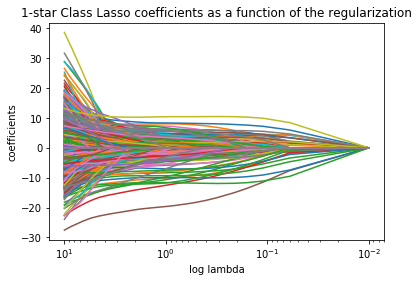

In [33]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel('log lambda')
plt.ylabel('coefficients')
plt.title('1-star Class Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.savefig('test.png', dpi=900)
plt.show()

Generate CV data for plot.

In [34]:
plot_cv = []
param_grid = {'C': np.linspace(0.01, 10, num=200)}
better_model = GridSearchCV(LogisticRegression(penalty='l1'),
                              param_grid, scoring=score, cv=5, n_jobs=4, verbose=2)
better_model.fit(x_train, y_train)
dump(better_model, open('./config/model{}.pickle'.format('_cv_plot'), 'wb'))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   1.8s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   2.0s
[CV] C=0.0602010050251 ...............................................
[CV] ........................................... C=0.01, total=   1.8s
[CV] ........................................... C=0.01, total=   2.0s
[CV] C=0.0602010050251 ...............................................
[CV] C=0.0602010050251 ...............................................
[CV] ........................................... C=0.01, total=   1.8s
[CV] C=0.0602

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   48.2s


[CV] ................................. C=0.311206030151, total=   6.4s
[CV] C=0.361407035176 ................................................
[CV] ................................. C=0.311206030151, total=   6.5s
[CV] C=0.361407035176 ................................................
[CV] ................................. C=0.361407035176, total=   7.2s
[CV] C=0.361407035176 ................................................
[CV] ................................. C=0.361407035176, total=   7.3s
[CV] C=0.411608040201 ................................................
[CV] ................................. C=0.361407035176, total=   6.9s
[CV] C=0.411608040201 ................................................
[CV] ................................. C=0.361407035176, total=   7.1s
[CV] C=0.411608040201 ................................................
[CV] ................................. C=0.361407035176, total=   7.2s
[CV] C=0.411608040201 ................................................
[CV] .

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  6.6min


[CV] .................................. C=1.51603015075, total=  13.3s
[CV] C=1.56623115578 .................................................
[CV] .................................. C=1.56623115578, total=  12.1s
[CV] C=1.56623115578 .................................................
[CV] .................................. C=1.56623115578, total=  10.7s
[CV] C=1.6164321608 ..................................................
[CV] .................................. C=1.56623115578, total=  11.1s
[CV] C=1.6164321608 ..................................................
[CV] .................................. C=1.56623115578, total=  11.1s
[CV] C=1.6164321608 ..................................................
[CV] .................................. C=1.56623115578, total=  11.0s
[CV] C=1.6164321608 ..................................................
[CV] ................................... C=1.6164321608, total=  11.4s
[CV] C=1.6164321608 ..................................................
[CV] .

[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 19.1min


[CV] .................................. C=3.57427135678, total=  17.2s
[CV] C=3.62447236181 .................................................
[CV] .................................. C=3.57427135678, total=  17.1s
[CV] C=3.62447236181 .................................................
[CV] .................................. C=3.57427135678, total=  17.1s
[CV] C=3.62447236181 .................................................
[CV] .................................. C=3.62447236181, total=  18.0s
[CV] C=3.62447236181 .................................................
[CV] .................................. C=3.62447236181, total=  18.4s
[CV] C=3.67467336683 .................................................
[CV] .................................. C=3.62447236181, total=  18.1s
[CV] C=3.67467336683 .................................................
[CV] .................................. C=3.62447236181, total=  17.3s
[CV] C=3.67467336683 .................................................
[CV] .

[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 43.5min


[CV] .................................. C=6.43572864322, total=  22.4s
[CV] C=6.43572864322 .................................................
[CV] .................................. C=6.43572864322, total=  22.5s
[CV] C=6.48592964824 .................................................
[CV] .................................. C=6.43572864322, total=  21.9s
[CV] C=6.48592964824 .................................................
[CV] .................................. C=6.43572864322, total=  22.2s
[CV] C=6.48592964824 .................................................
[CV] .................................. C=6.43572864322, total=  21.8s
[CV] C=6.48592964824 .................................................
[CV] .................................. C=6.48592964824, total=  21.7s
[CV] C=6.48592964824 .................................................
[CV] .................................. C=6.48592964824, total=  21.4s
[CV] C=6.53613065327 .................................................
[CV] .

[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed: 82.3min finished


5-Fold CV Confusion Matrix

In [51]:
scores = (-1) * better_model.cv_results_['mean_test_score']
index = np.linspace(0.01, 10, num=200)
table = pd.DataFrame()
table['error'] = scores
table['index'] = index

In [52]:
table.to_csv('./config/cv_result.csv')

In [23]:
test = LogisticRegression(C=0.089, penalty='l2')
test.fit(x_train, y_train)
predict(test, all_mat, x_train.shape[0], './config/prediction_test.csv')

Successfully load predicting text, with shape (24461, 21888).


Plot confusion matrix.

In [144]:
"""
The code is copied form the sklearn documentation
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Rating')
    plt.xlabel('Predicted Rating')

In [146]:
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
import itertools

cv = KFold(24461, n_folds=10,shuffle=False,random_state=None)

ms = []

# Make confusion matrix for each fold
for train_in, test_in in cv:
    x_train_, x_test_ = x_train[train_in,], x_train[test_in,]
    y_train_, y_test_ = np.array(y_train)[train_in], np.array(y_train)[test_in]
    
    test = LogisticRegression(C=2.3877551020408161)
    test.fit(x_train_, y_train_)
    y_pred=clf.predict(x_test_)
    
    print(len(y_pred))
    
    cnfusion_matrix_ = confusion_matrix(y_test_, y_pred)
    ms.append(cnfusion_matrix_)

2447
2446
2446
2446
2446
2446
2446
2446
2446
2446


Confusion matrix, without normalization
[[204   6   2   1   0]
 [  9 232  14   8   2]
 [  4  11 299  41  15]
 [  1   2  19 632 106]
 [  0   0   5  71 751]]


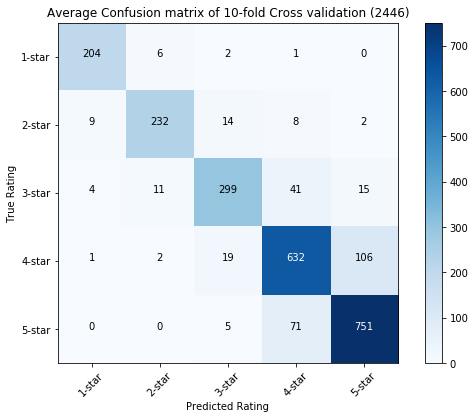

In [154]:
avg_matrix = sum(ms) / 10.0

plt.figure(figsize=(8,6))
plot_confusion_matrix(avg_matrix.astype(int), classes=["1-star","2-star","3-star","4-star","5-star"],
                      title='Average Confusion matrix of 10-fold Cross validation (2446)')
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('./plot/confusion_matrix.png', dpi=700)
plt.show()

## Chi 2 test

In [83]:
from sklearn.feature_selection import chi2

chi2, pval = chi2(x_train, y_train)

array([  4.27e+02,   1.56e+00,   3.95e+01,   1.19e+01,   5.02e+00,
         5.00e+00,   1.98e+00,        nan,   1.55e+00,   5.92e-01,
         7.21e-01,   3.09e-01,   7.68e-01,   1.29e+00,   3.07e+01,
         1.96e+00,   1.44e+00,   6.57e-01,   4.11e+00,   1.61e+00,
         1.32e+00,   2.99e-01,   1.31e+01,   9.03e+01,   6.53e-01,
         9.39e+00,   9.26e+00,   2.67e+00,   5.68e+00,        nan,
         1.69e+00,   2.11e+00,   1.27e+00,   4.76e-01,   1.17e+00,
              nan,   1.96e-01,   6.31e-01,   3.37e-01,   7.29e-01,
              nan,   5.90e-01,   1.62e+00,   2.28e+01,   6.11e+00,
         5.64e+00,   9.55e-01,   1.19e+00,   7.98e-01,   2.12e+00,
         1.31e+00,   2.12e-01,   2.58e+00,   1.32e+00,   1.55e+00,
         2.04e+00,   5.03e-01,   6.25e-01,   8.21e-01,   2.19e-01,
              nan,        nan,   3.62e-01,   1.20e+00,   5.66e-01,
         5.09e-01,   5.38e-01,   3.21e-01,   4.26e-01,   3.04e-01,
         2.13e+00,   1.04e+00,   9.99e-01,   9.17e-01,   1.78e

In [96]:
test = LogisticRegression(C=2.3877551020408161, penalty='l1')
test.fit(x_train, y_train)

LogisticRegression(C=2.387755102040816, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [98]:
index_coef = []
for i in range(len(test.coef_[0])):
    if test.coef_[0][i] != 0:
        index_coef.append(i)

In [99]:
len(index_coef)

1394

In [101]:
pval[index_coef]

array([  4.67e-91,   8.16e-01,   5.43e-08, ...,   6.86e-06,   8.80e-07,
         4.23e-12])

In [104]:
total = 0
for i in pval[index_coef]:
    if i > 0.05:
        total += 1
total

940

In [135]:
index_coef = np.argpartition(test.coef_[4], -10)[-10:]
total = 0
for i in pval_[index_coef]:
    if i > 0.05:
        total += 1
    print(i)

AttributeError: 'LogisticRegression' object has no attribute 'coef'

In [119]:
for i in index_coef:
    for k, v in tf.vocabulary_.items():
        if i == v:
            print(k)
print(len(tf.vocabulary_.items())) 

exceed
superb
sophia
favorit
masterpiec
best
hue
amaz
mmmmmmm
banzo
21888


In [125]:
tf, all_mat_c, x_train_c = vectorize_text_count(TRAIN_TEXT, VALI_TEXT, TEST_TEXT, 
                                      vector='../../static/count_vector.pickle', 
                                      matrix='../../static/count_matrix.pickle', re_load=False)

Successfully load TF-IDF matrix, with shape (36692, 55778).


In [128]:
from sklearn.feature_selection import chi2
chi2_, pval_ = chi2(x_train_c, y_train)

In [134]:
print(x_train_c[0,])

  (0, 26088)	1
  (0, 46926)	1
  (0, 46062)	1
  (0, 43848)	1
  (0, 40223)	1
  (0, 10618)	1
  (0, 10839)	1
  (0, 40734)	1
  (0, 42553)	1
  (0, 41859)	1
  (0, 40894)	1
  (0, 47686)	1
  (0, 17034)	1
  (0, 23440)	1
  (0, 33276)	1
  (0, 31903)	1
  (0, 42271)	1
  (0, 39325)	1
  (0, 8295)	1
  (0, 42914)	1
  (0, 18244)	1
  (0, 37959)	1
  (0, 29715)	1
  (0, 42807)	1
  (0, 23933)	1
  :	:
  (0, 21205)	1
  (0, 36524)	1
  (0, 40442)	1
  (0, 47080)	1
  (0, 45157)	1
  (0, 1243)	3
  (0, 39672)	1
  (0, 41756)	1
  (0, 22001)	1
  (0, 26856)	1
  (0, 12619)	1
  (0, 15378)	2
  (0, 9418)	1
  (0, 19668)	2
  (0, 9670)	1
  (0, 16395)	1
  (0, 8084)	1
  (0, 623)	8
  (0, 17377)	2
  (0, 19664)	1
  (0, 24)	2
  (0, 55202)	1
  (0, 34128)	1
  (0, 0)	4
  (0, 46446)	1


In [186]:
def tokenize_no_stop(text):
    """ Helper function for TFIDF vector from sklearn. We use nltk's tokenize
        function here. Also use snowball as stemmer (the middle agressive
        one).
    """
    # Filter out stop words, tokenize the text
    useful_token = [w.lower() for w in word_tokenize(text)]

    # Stemming the tokens
    stemmed_token = [STEMMER.stem(t) for t in useful_token]

    return stemmed_token

In [187]:
def vectorize_text_no(train_txt, vali_txt, test_txt, vector, matrix, re_load,
                   min_df=1, max_df=1.0, max_feature=None, min_n=1, max_n=1):
    """ Feature engineering from the raw text input. """
    # If there is saved model, then just use it
    if exists(vector) and exists(matrix) and not re_load:
        # Get train length
        table_train = pd.read_csv(train_txt)

        # Load stored data
        all_mat = load(open(matrix, 'rb'))
        x_train = all_mat[:table_train.shape[0]]
        tf = load(open(vector, 'rb'))

    else:
        # Read all files
        table_train = pd.read_csv(train_txt)
        table_test = pd.read_csv(vali_txt)
        table_vali = pd.read_csv(test_txt)

        text_train = table_train['clean'].tolist()
        text_test = table_test['clean'].tolist()
        text_vali = table_vali['clean'].tolist()

        # We want to have a overall vocabulary bank as `np.py`, so we combine
        # all the text first
        all_text = text_train + text_test + text_vali

        # Record the length so we can recover the training set
        train_length = len(text_train)

        # Initialize TFID arguments
        # Only work for English, discard all Chinese
        tf = TfidfVectorizer(min_df=min_df, max_features=max_feature,
                             strip_accents='ascii', analyzer='word',
                             tokenizer=tokenize_no_stop, ngram_range=(min_n, max_n))

        # Vectorize all, and transform (more efficient than fit + transform)
        all_mat = tf.fit_transform(all_text)

        # Recover the training data
        x_train = all_mat[:train_length]

        # Store the fitted matrix and tf_vectorizor
        dump(all_mat, open(matrix, 'wb'))
        dump(tf, open(vector, 'wb'))

    print("Successfully load TF-IDF matrix, with shape {}.".format(
        x_train.shape))

    return tf, all_mat, x_train

In [157]:
tf_no, all_mat_no, x_train_no = vectorize_text(TRAIN_TEXT, TEST_TEXT, VALI_TEXT,
                                      "./config/tf_nostop.pickle", 
                                      "./config/matrix_nostop.pickle", False,
                                      min_df=MIN_DF, max_df=MAX_DF,
                                      max_feature=MAX_FEATURE,
                                      min_n=MIN_N, max_n=MAX_N)

# Make label for train_v
table_train = pd.read_csv(TRAIN_TEXT)

# Use string to represent the categories
y_train = list(map(str, table_train['stars']))

Successfully load TF-IDF matrix, with shape (36692, 21974).


In [158]:
test = LogisticRegression(C=2.3877551020408161, penalty='l1')
test.fit(x_train_no, y_train)

LogisticRegression(C=2.387755102040816, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [159]:
np.mean(cross_val_score(test, x_train_no, y_train, cv=10,
                                scoring=score))

-0.72518967618208174

In [160]:
predict(test, all_mat_no, x_train_no.shape[0], './config/prediction_test.csv')

Successfully load predicting text, with shape (24461, 21974).


In [162]:
test_r = LogisticRegression(C=6, penalty='l2')
test_r.fit(x_train_no, y_train)

LogisticRegression(C=6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [164]:
predict(test_r, all_mat_no, x_train_no.shape[0], './config/prediction_test.csv')

Successfully load predicting text, with shape (24461, 21974).


In [165]:
STOP

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 'd',
 'did',
 'didn',
 'do',
 'does',
 'doesn',
 'doing',
 'don',
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 'has',
 'hasn',
 'have',
 'haven',
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 'it',
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 'more',
 'most',
 'mustn',
 'my',
 'myself',
 'needn',
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'shan',
 'she',
 'should',
 'shouldn',
 'so',
 'some',
 'such',
 't',
 'than',
 'that',
 'the',
 'their',
 'theirs',
 'them',
 

In [168]:
model_no = SelectFromModel(test)
model_no.fit(x_train_no, y_train)
all_mat_no_s = model_no.transform(all_mat_no)
x_train_no_s = model_no.transform(x_train_no)
x_train_no_s.shape

(36692, 4838)

In [ ]:
for i in range(len(test.coef_[0])):
    if test.coef_[0][i] != 0 or test.coef_[1][i] != 0 or test.coef_[2][i] != 0 or 
        test.coef_[3][i] != 0 or test.coef_[4][i] != 0:
            

In [173]:
tt = LogisticRegression(C=2.3877551020408161, penalty='l1')
tt.fit(x_train_no, y_train)

LogisticRegression(C=2.387755102040816, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [174]:
model_no = SelectFromModel(tt)
model_no.fit(x_train, y_train)

x_train_s = model_no.transform(x_train)
x_train_s.shape

(36692, 5288)

In [179]:
final = LogisticRegression(C=2.3877551020408161, penalty='l1')
final.fit(x_train, y_train)

LogisticRegression(C=2.387755102040816, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [180]:
predict(final, all_mat, x_train.shape[0], './config/prediction_final_model.csv')

Successfully load predicting text, with shape (24461, 21888).


## Possible improvement?

In [181]:
# Reverse Dictionary for no_stop
tf_no_re = {}
for k, v in tf_no.vocabulary_.items():
    tf_no_re[v] = k

In [182]:
test

LogisticRegression(C=2.387755102040816, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [185]:
for i in range(len(test.coef_[0])):
    if test.coef_[0][i] != 0 or test.coef_[1][i] != 0 or test.coef_[2][i] != 0 or \
        test.coef_[3][i] != 0 or test.coef_[4][i] != 0:
            if tf_no_re[i] in STOP:
                print(tf_no_re[i])

a
about
after
again
against
ain
all
am
an
and
are
aren
as
at
be
been
below
between
both
but
by
can
couldn
did
didn
do
doesn
don
down
each
few
for
from
further
had
hadn
has
hasn
have
haven
he
her
here
herself
him
his
how
i
if
in
into
is
isn
it
itself
just
ll
m
ma
me
more
most
my
myself
no
nor
not
now
o
of
off
on
or
other
our
out
over
own
re
s
same
she
should
shouldn
so
some
such
t
than
that
the
their
them
then
there
these
they
this
those
through
to
too
under
until
up
ve
was
wasn
we
were
weren
what
when
where
which
while
who
whom
will
with
won
wouldn
you
your
yourself


### Try a less aggressive stemmer

In [188]:
from nltk.stem import RegexpStemmer
STEMMER = SnowballStemmer("english")

In [190]:
tf_no_porter, all_mat_no_porter, x_train_no_porter = vectorize_text_no(TRAIN_TEXT, TEST_TEXT, VALI_TEXT,
                                      "./config/tf_nostop_p.pickle", 
                                      "./config/matrix_nostop_p.pickle", True,
                                      min_df=MIN_DF, max_df=MAX_DF,
                                      max_feature=MAX_FEATURE,
                                      min_n=MIN_N, max_n=MAX_N)

# Make label for train_v
table_train = pd.read_csv(TRAIN_TEXT)

# Use string to represent the categories
y_train = list(map(str, table_train['stars']))

Successfully load TF-IDF matrix, with shape (36692, 21974).


In [ ]:
test_r_p = LogisticRegression(C=6, penalty='l2')
test_r_p.fit(x_train_no_porter, y_train)

In [191]:
param_grid = {'C': np.linspace(1,10,5)}
better_model = GridSearchCV(LogisticRegression(penalty='l2', dual=False),
                          param_grid, scoring=score, cv=5, n_jobs=4, verbose=2)

better_model.fit(x_train_no_porter, y_train)
dump(better_model, open('./config/model{}.pickle'.format('_ridge_nostop_p'), 'wb'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=1.0 ...........................................................
[CV] C=1.0 ...........................................................
[CV] C=1.0 ...........................................................
[CV] C=1.0 ...........................................................
[CV] ............................................ C=1.0, total=   8.1s
[CV] C=1.0 ...........................................................
[CV] ............................................ C=1.0, total=   8.1s
[CV] C=3.25 ..........................................................
[CV] ............................................ C=1.0, total=   8.4s
[CV] C=3.25 ..........................................................
[CV] ............................................ C=1.0, total=   8.5s
[CV] C=3.25 ..........................................................
[CV] ............................................ C=1.0, total=   9.5s
[CV] C=3.25 .....

[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  1.4min finished


In [194]:
cv_result_better = pd.DataFrame.from_dict(better_model.cv_results_, orient='index')
predict_mlr(better_model, all_mat_no_porter, x_train_no_porter.shape[0], './config/prediction_test.csv')
cv_result_better

Successfully load predicting text, with shape (24461, 21974).


,0,1,2,3,4
split1_train_score,-0.700748,-0.614704,-0.576698,-0.55137,-0.532244
rank_test_score,5,3,1,2,4
mean_fit_time,8.40018,12.0758,12.9925,14.0881,14.5749
std_fit_time,0.512284,0.473757,0.209709,0.599084,2.23651
param_C,1,3.25,5.5,7.75,10
mean_train_score,-0.700088,-0.614027,-0.576014,-0.550676,-0.531548
split0_test_score,-0.756408,-0.723055,-0.719313,-0.720335,-0.722827
std_test_score,0.00227796,0.00462168,0.00563095,0.00622247,0.00662464
split2_train_score,-0.698732,-0.612468,-0.574731,-0.54964,-0.53069
split4_test_score,-0.76154,-0.730361,-0.726943,-0.727804,-0.729941
